# Examining Network Features

In this notebook, I reproduce several methods of network analysis, especially those identified in “Complex Contagions and the Diffusion of Popular Twitter Hashtags in Nigeria.” Fink et al. (2015), a previous study examining simple versus current complex contagion which has been influential.

First however, I do some data processing in order to construct network visualizations.

In [1]:
from sqlitedict import SqliteDict
import pandas as pd
import geopandas as gpd
from pyarrow import feather
import matplotlib.pyplot as plt
import math
import numpy as np

import utils.common.constants as c
from utils.data_analysis.load_edges import load_edges_df, load_geo_edges_df
from utils.data_analysis.load_users import load_users_dfs

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Path to Utils: /Volumes/rc/lab/S/SIGIL/crist/utils


## Convert pandas data frame into GEPHI friendly format, save

In this section, I save my network edges data (saved in friends.sqlite) in a format such that I can use a popular graph visualization software, GEPHI. See my published results for those visuals.

Note: friends  Is the term defined by Twitter to refer to the users that an account follows.

When including all friends, geo-tagged and not, there are 80+ million edges in the graph. Because GEPHI can only handle 1 million edges, I specifically look at geo-edges for building my network.

In [ ]:
geo_edges_df = load_geo_edges_df()
geo_edges_df

In [ ]:
geo_users_w_info_gdf = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
geo_users_w_info_gdf

In [4]:
csubs_with_info_gdf = gpd.read_feather("utils/data_analysis/feathers/csubs_w_info_gdf.ftr")
csubs_with_info_gdf

,Geo_FIPS,Geo_QNAME,geometry,Geo_NAME,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerCap,PKPerSqMile,Blck_Wht_PerCap_Ratio,Adopters,AdoptersPerCap,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std,cluster_label
0,1500791620,Koloa-Poipu CCD,"POLYGON ((-159.47758 21.94446, -159.47681 21.9...",Koloa-Poipu CCD,15.0,7.0,91620.0,6513.0,267.959400,24.305920,2611.0,33.0,3869.0,40.09,0.51,59.40,13.86,49205.0,24639.0,12977.0,35558.0,0.0,0.0,0.0,0.500742,0.0,0.000000,-0.431877,-0.579824,-1.630472,-0.779372,0.815802,-0.120894,5
1,1500791440,Kekaha-Waimea CCD,"MULTIPOLYGON (((-159.78534 22.01540, -159.7854...",Kekaha-Waimea CCD,15.0,7.0,91440.0,5424.0,60.076390,90.285045,987.0,35.0,4402.0,18.20,0.65,81.16,13.74,40439.0,NaN,22627.0,33280.0,0.0,0.0,0.0,NaN,0.0,0.000000,-0.461690,-0.579824,-2.000000,-0.770412,0.197990,-0.035321,5
2,1500790180,Eleele-Kalaheo CCD,"POLYGON ((-159.55515 21.94415, -159.55503 21.9...",Eleele-Kalaheo CCD,15.0,7.0,90180.0,9552.0,265.937900,35.918159,2719.0,4.0,6829.0,28.47,0.04,71.50,13.30,43940.0,NaN,22011.0,31674.0,0.0,0.0,0.0,NaN,0.0,0.000000,-0.432167,-0.579824,-2.000000,-0.809449,0.444734,-0.035321,5
3,1500791260,Kaumakani-Hanapepe CCD,"MULTIPOLYGON (((-159.66121 21.94349, -159.6611...",Kaumakani-Hanapepe CCD,15.0,7.0,91260.0,4201.0,34.652970,121.230572,506.0,5.0,3690.0,12.04,0.12,87.83,9.31,30089.0,NaN,24595.0,26411.0,0.0,0.0,0.0,NaN,0.0,0.000000,-0.465335,-0.579824,-2.000000,-0.804329,-0.531458,-0.035321,5
4,1500792160,Lihue CCD,"POLYGON ((-159.34601 21.95641, -159.34656 21.9...",Lihue CCD,15.0,7.0,92160.0,7058.0,1147.636000,6.150035,1528.0,127.0,5403.0,21.65,1.80,76.55,12.99,50783.0,45691.0,20009.0,33228.0,0.0,0.0,0.0,0.899730,2.0,0.000283,-0.305723,-0.579824,-2.000000,-0.696819,0.927016,1.709886,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36094,2707152990,Rainy Lake UT,"MULTIPOLYGON (((-93.51728 48.35536, -93.51727 ...",Rainy Lake UT,27.0,71.0,52990.0,3084.0,8.768746,351.703622,2977.0,0.0,107.0,96.53,0.00,3.47,3.18,40708.0,NaN,24543.0,40094.0,0.0,0.0,0.0,NaN,0.0,0.000000,-0.469048,-0.579824,1.215470,-0.812009,0.216949,-0.035321,0
36095,2707131040,International Falls city,"POLYGON ((-93.41918 48.57652, -93.42108 48.576...",International Falls city,27.0,71.0,31040.0,5981.0,932.249700,6.415663,5584.0,70.0,327.0,93.36,1.17,5.47,0.48,26352.0,3049.0,4041.0,25347.0,0.0,0.0,0.0,0.115703,0.0,0.000000,-0.336612,-0.579824,1.055625,-0.737136,-0.794835,-1.998461,4
36096,2707153134,Ranier city,"POLYGON ((-93.34008 48.61384, -93.34018 48.613...",Ranier city,27.0,71.0,53134.0,626.0,4356.886000,0.143681,552.0,0.0,74.0,88.18,0.00,11.83,1.44,40754.0,NaN,NaN,38208.0,0.0,0.0,0.0,NaN,0.0,0.000000,0.154512,-0.579824,0.794428,-0.812009,0.220191,-0.035321,0
36097,2713732252,Kabetogama township,"MULTIPOLYGON (((-93.09089 48.48749, -93.09086 ...",Kabetogama township,27.0,137.0,32252.0,104.0,6.397906,16.255319,104.0,0.0,0.0,100.00,0.00,0.00,0.00,37804.0,NaN,NaN,37804.0,0.0,0.0,0.0,NaN,0.0,0.000000,-0.469388,-0.579824,1.390442,-0.812009,0.012280,-0.035321,0


Lastly, my colors and labels for each cluster:

In [5]:
colors = {0:'black', 1:'violet', 2:'orange', 3:'lightseagreen', 4:'red', 5:'blue'}
markers = {0:'X', 1:'s', 2:'D', 3:'v', 4:'^', 5:'<'}
labels = {0:'Rur.White', 1:'Sub.Blacker', 2:'Sub.Richer', 3:'BigCities', 4:'SubRur.Poorer', 5:'MidCities'}

And a groupby object for each cluster:

In [6]:
users_clusters = geo_users_w_info_gdf.groupby("cluster_label")
csub_clusters = csubs_with_info_gdf.groupby("cluster_label")

In [7]:
pop_and_adopt = csub_clusters.agg({
    "Total_Pop": "sum",
    "Adopters": "sum"
})
pop_and_adopt["AdoptPerCap"] = pop_and_adopt["Adopters"] / pop_and_adopt["Total_Pop"]
pop_and_adopt = pop_and_adopt.sort_values(by="AdoptPerCap")

for label in pop_and_adopt.index:
    print(f"({label}) {labels[label]}: {pop_and_adopt.loc[label, 'AdoptPerCap'].round(6)}")

(0) Rur.White: 3.8e-05
(4) SubRur.Poorer: 5.4e-05
(2) Sub.Richer: 9.2e-05
(5) MidCities: 0.000122
(1) Sub.Blacker: 0.000128
(3) BigCities: 0.000371


### GEPHI Requirements

I'll pass a thinned version of my detailed information to GEPHI so it doesn't die. I will filter the edges based on being in geo_users_df -- which, unlike geo_users_w_info, includes all users w a geotag who I couldn't pinpoint.

In [8]:
_, geo_users_df = load_users_dfs()

In [9]:
just_geo_edges_df = geo_edges_df.loc[geo_edges_df["Source"].isin(geo_users_df[c.U_ID])]
just_geo_edges_df = just_geo_edges_df.loc[just_geo_edges_df["Target"].isin(geo_users_df[c.U_ID])]

just_geo_edges_df.to_csv("gephi_data/geousers_edge_data.csv", index=False, header=True)
geo_users_w_info_gdf.rename(columns={c.U_ID: "Id"}).to_csv("gephi_data/geousers_node_data.csv", index=False, header=True)

## Examine Clusters' Properties

Copied from `examine_salient_characteristics`, included here for ease of visibility:

In [10]:
users_clusters.mean()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,Private,prior_adopter,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1979.658541,2.943033e+09,29.338892,1.030784e+05,1590.101309,154.316535,87232.906545,3865.024229,11980.501259,87.485088,3.811048,8.704160,15.310865,36544.458779,27767.964224,23462.012687,35276.216174,2.212712,0.019181,0.794987,1218.264003,1795.326935,16103.301447,0.0,0.231907,-0.242277,-0.417773,0.759388,-0.568124,-0.076490,0.135309
1,1618.960442,2.799112e+09,27.877563,3.094520e+05,2960.041066,119.726615,144319.959188,129998.358985,35133.700711,44.699970,44.865228,10.435271,11.923235,39039.420711,21605.758327,19233.067634,29593.147411,11.354315,0.103193,0.607811,1231.391472,2094.513299,19111.937868,0.0,0.357563,-0.046539,0.289542,-1.398018,2.059103,0.099351,-0.384608
2,1872.760148,2.483932e+09,24.765887,2.632843e+05,3217.196343,191.893048,154577.785525,13629.055825,95077.457414,72.041556,6.053780,21.903698,14.070900,57882.310680,39853.790222,31189.578924,52937.815093,4.603928,0.036028,0.725081,1250.728597,2598.819064,15020.434466,0.0,0.268314,-0.011072,-0.276817,-0.019340,-0.424602,1.427362,1.193517
3,1126.472125,2.194502e+09,21.886578,1.634283e+06,19941.938921,126.440761,779464.706954,341510.611752,513308.104646,48.146264,22.451591,29.402745,29.389379,56991.674998,27075.612992,23487.348598,42579.297148,44.142230,0.360598,0.526673,1258.861490,5884.178670,15942.633693,0.0,0.345512,2.389552,2.467389,-1.224241,0.624761,1.364592,0.091005
4,1822.509666,3.236831e+09,32.279429,1.506741e+05,1779.795450,187.978588,121565.459207,9747.902972,19360.747960,81.710245,7.773931,10.515446,25.488444,27800.281469,16439.323203,17435.332158,26096.923077,6.354895,0.040793,0.618901,1124.858100,1848.830711,16244.204545,0.0,0.243298,-0.215164,-0.235749,0.468196,-0.314523,-0.692763,-0.831649
5,1723.955642,2.660796e+09,26.504407,1.114124e+06,3386.916815,342.314495,725562.593946,135507.587176,253053.488313,65.477786,12.416652,22.105102,29.962593,37634.861796,24844.980164,20491.241534,33336.929493,40.344744,0.107815,0.675084,1081.865117,2174.665219,17085.068463,0.0,0.292502,0.015343,0.331062,-0.350313,-0.017416,0.000360,-0.102852


In [11]:
users_clusters.median()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,BlackPopPerc,OtherRacePopPerc,PctLatinoPop,WhitePerCap,BlackPerCap,LatinoPerCap,PerCap,PoliceKillings,PKPerSqMile,Blck_Wht_PerCap_Ratio,Following,Followers,Tweets,Private,prior_adopter,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.328306e-10,2.705355e+09,27.0,47460.0,1263.530,38.440101,40641.0,1855.0,4044.5,88.41,2.93,7.620,7.790,37009.0,26712.0,22103.0,35544.0,0.0,0.000000,0.752468,556.5,373.5,6333.5,0.0,0.0,-0.288560,-0.579824,0.806026,-0.624506,-0.043750,0.010075
1,2.328306e-10,2.616189e+09,26.0,198051.0,2825.840,77.942415,99169.0,73115.0,19756.0,46.97,41.04,8.430,7.680,35313.0,20004.0,17613.0,29040.0,6.0,0.084768,0.566477,656.0,514.0,7763.0,0.0,0.0,-0.070900,0.136502,-1.283553,1.814310,-0.163281,-0.523975
2,2.399963e-10,2.501711e+09,25.0,117967.0,2649.187,53.512279,81259.0,5324.0,24510.0,74.98,4.29,19.180,12.960,55084.0,38137.0,27522.0,50891.0,1.0,0.014559,0.673769,576.0,409.5,5657.0,0.0,0.0,-0.090387,-0.437040,0.128829,-0.537474,1.230143,1.050433
3,2.328306e-10,1.703114e+09,17.0,1631993.0,11346.450,70.815778,922033.0,309287.0,468967.0,47.78,18.29,28.730,25.830,49239.0,29520.0,21331.0,37306.0,31.0,0.363621,0.522695,631.0,544.0,5727.0,0.0,0.0,1.156880,2.492935,-1.242709,0.358444,0.818198,0.303580
4,1.164153e-10,3.500593e+09,35.0,54333.0,1204.438,64.473127,42622.0,3721.0,5539.0,82.57,5.81,9.375,11.155,27600.0,17439.0,16846.0,25661.5,1.0,0.011732,0.625461,574.0,430.0,6886.5,0.0,0.0,-0.295534,-0.479146,0.511548,-0.440203,-0.706879,-0.744083
5,2.328306e-10,2.712356e+09,27.0,666032.0,3492.922,211.611445,431292.0,58607.0,119434.0,67.23,10.93,19.620,32.720,37305.0,23764.0,20068.0,32370.0,26.0,0.106858,0.669585,559.0,420.0,6614.0,0.0,0.0,0.030612,0.323169,-0.261959,-0.112553,-0.022888,-0.196988


Next, I want to identify the most representative (as well as highest-adopting) subdivisions in each cluster:

In [12]:
# FROM HERE: https://stackoverflow.com/questions/26102867/python-weighted-median-algorithm-with-pandas

def wtd_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

# Sort each cluster by the subdivisions which minimize mean error

def find_most_rep(cluster):
    
    cols = ['Pop_Dens','PKPerSqMile','WhitePopPerc','BlackPopPerc','WhitePerCap','BlackPerCap']
    std_cols = [f"{col}_std" for col in cols]
    
    dist_to_mean_df = cluster[std_cols + ["Geo_FIPS", "Total_Pop"]]
    stats_df = dist_to_mean_df.describe()
    
    for col in std_cols:
        dist_to_mean_df[col] = (dist_to_mean_df.loc[:,col] - wtd_median(dist_to_mean_df, col, "Total_Pop"))**2
        
    dist_to_mean_df.loc[:,"dist_to_mean"] = dist_to_mean_df[std_cols].sum(axis=1)
    return dist_to_mean_df.sort_values(by="dist_to_mean")



In [13]:
state_labels_df = pd.read_csv('utils/data_analysis/datasets/StateLabels.csv')
state_labels_df

,STATE_NAME,Geo_STATE,STATE_ABBR
0,Alabama,1,AL
1,Alaska,2,AK
2,Arizona,4,AZ
3,Arkansas,5,AR
4,California,6,CA
5,Colorado,8,CO
6,Connecticut,9,CT
7,Delaware,10,DE
8,District of Columbia,11,DC
9,Florida,12,FL


In [14]:
for label, cluster in csub_clusters:
    
    cluster_subcols = cluster[["Geo_FIPS", "Geo_QNAME", "Geo_STATE", "Adopters", "PerCap", "WhitePopPerc", "BlackPopPerc", "Pop_Dens", "PKPerSqMile"]]
    cols_to_print = ["Geo_QNAME", "STATE_NAME", "Adopters", "PerCap", "WhitePopPerc", "BlackPopPerc", "Pop_Dens", "PKPerSqMile"] 
    
    top_places_df = cluster_subcols
    top_places_df = top_places_df.merge(
        state_labels_df, 
        on="Geo_STATE"
    )
    top_places_df.drop(columns=["Geo_STATE", "STATE_ABBR"], inplace=True)
    top_places_df = top_places_df.sort_values("Adopters", ascending=False)
    
    most_avg_places = find_most_rep(cluster)
    most_avg_places = most_avg_places.merge(
        cluster_subcols, 
        on="Geo_FIPS"
    )
    most_avg_places = most_avg_places.merge(
        state_labels_df, 
        on="Geo_STATE"
    )      
    print(f"***********\n\nCluster {label}:")
    print("AVERAGE:")
    print(most_avg_places[cols_to_print].head(4))
    print("\nTOP:")
    print(top_places_df[cols_to_print].head(2))
    print()

***********

Cluster 0:
AVERAGE:
              Geo_QNAME    STATE_NAME  Adopters   PerCap  WhitePopPerc  BlackPopPerc    Pop_Dens  PKPerSqMile
0       Petersburg city  North Dakota       0.0  31976.0         91.23          1.75  165.453000          0.0
1           Wishek city  North Dakota       0.0  31248.0         92.52          1.48  657.073200          0.0
2        Hannaford city  North Dakota       0.0  31810.0         92.44          0.00  543.259600          0.0
3  Lake George township  North Dakota       0.0  31689.0         91.89          0.00    1.049698          0.0

TOP:
                     Geo_QNAME  STATE_NAME  Adopters   PerCap  WhitePopPerc  BlackPopPerc  Pop_Dens  PKPerSqMile
15162      Louisville East CCD    Kentucky      96.0  43416.0         90.46          5.15  3729.126     0.000000
79     Oceanside-Escondido CCD  California      78.0  35948.0         77.55          2.81  2461.743     0.044056

***********

Cluster 1:
AVERAGE:
                  Geo_QNAME STATE_NAME

/var/folders/1t/8mlwmmq90_92z_5p64h7l54m0000gn/T/ipykernel_97416/2277347734.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_to_mean_df[col] = (dist_to_mean_df.loc[:,col] - wtd_median(dist_to_mean_df, col, "Total_Pop"))**2
/Users/raycrist/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/var/folders/1t/8mlwmmq90_92z_5p64h7l54m0000gn/T/ipykernel_97416/2277347734.py:20: SettingWithCopyWarning: 
A value is tryin

Based on this, I label my 6 clusters:
    
| Cluster | Color      | Description | Examplary | Top |
| ----------- | ----------- | ----------- | ----------- |
| 0 (Rur.White) | Color      | Rural, Super White, $30K | Petersburg, ND | Louisville, KY |
| 1 (Sub.Blacker) | Color      | Suburban, Black-White, $25K  | Airport, MO | Atlanta, GA |
| 2 (Sub.Richer) | Color      | Suburban, Whiter, $50K | Burlington, MA | San Jose, CA |
| 3 (BigCities) | Color      | Super Urban, Diverse, $40K | Chicago, IL | Los Angeles, CA |
| 4 (SubRur.Poorer) | Color      | Suburban/Rural, Whiter, $25K | Alpine, MI | San Antonio, TX |
| 5 (MidCities) | Color      | Midsize Urban, Large Non-White/Black Pop, $30K | Maplewood city, MN | Houston, TX |

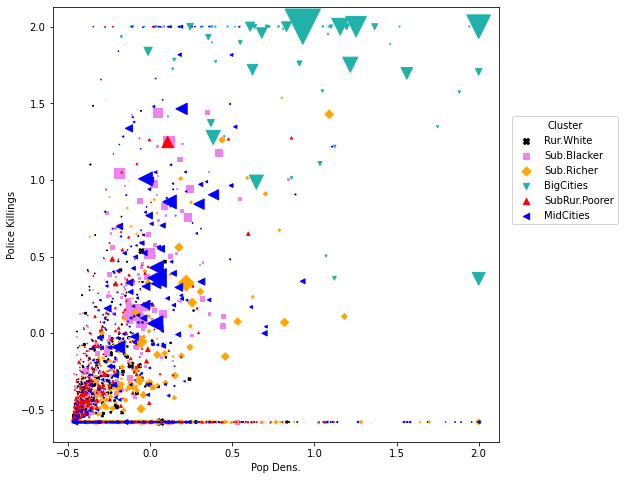

In [15]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))
ax = plt.axes()

for cluster_label, csub_cluster in csub_clusters:

    sctt = ax.scatter(
        x=csub_cluster['Pop_Dens_std'].clip(lower=-2.0, upper=2.0), 
        y=csub_cluster['PKPerSqMile_std'].clip(lower=-2.0, upper=2.0), 
        s=(csub_cluster['Adopters']**1/2),
        c=colors[cluster_label],
        marker=markers[cluster_label],
        label=labels[cluster_label]
    )
    
ax.set_xlabel('Pop Dens.')
ax.set_ylabel('Police Killings')

lgnd = ax.legend(loc=(1.03,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

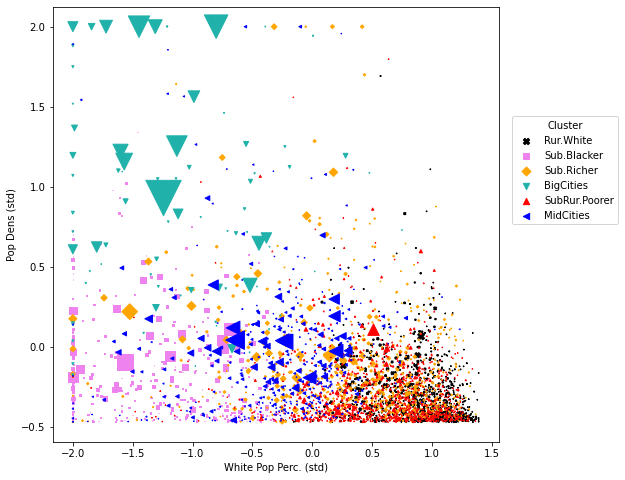

In [16]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))
ax = plt.axes()

for cluster_label, csub_cluster in csub_clusters:

    sctt = ax.scatter(
        x=csub_cluster['WhitePopPerc_std'].clip(lower=-2.0, upper=2.0), 
        y=csub_cluster['Pop_Dens_std'].clip(lower=-2.0, upper=2.0), 
        s=(csub_cluster['Adopters']**1/2),
        c=colors[cluster_label],
        marker=markers[cluster_label],
        label=labels[cluster_label]
    )
    
ax.set_xlabel('White Pop Perc. (std)')
ax.set_ylabel('Pop Dens (std)')

lgnd = ax.legend(loc=(1.03,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

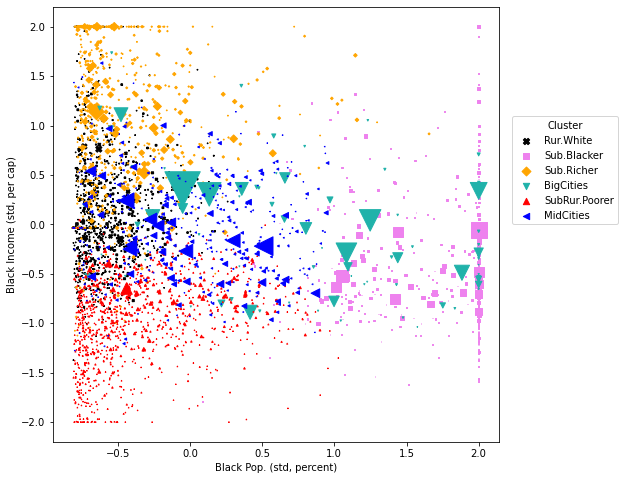

In [17]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))
ax = plt.axes()

for cluster_label, csub_cluster in csub_clusters:

    sctt = ax.scatter(
        x=csub_cluster['BlackPopPerc_std'].clip(lower=-2.0, upper=2.0), 
        y=csub_cluster['BlackPerCap_std'].clip(lower=-2.0, upper=2.0), 
        s=(csub_cluster['Adopters']**1/2),
        c=colors[cluster_label],
        marker=markers[cluster_label],
        label=labels[cluster_label]
    )
    
ax.set_xlabel('Black Pop. (std, percent)')
ax.set_ylabel('Black Income (std, per cap)')

lgnd = ax.legend(loc=(1.03,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

### View non-standardized distributions in 3D

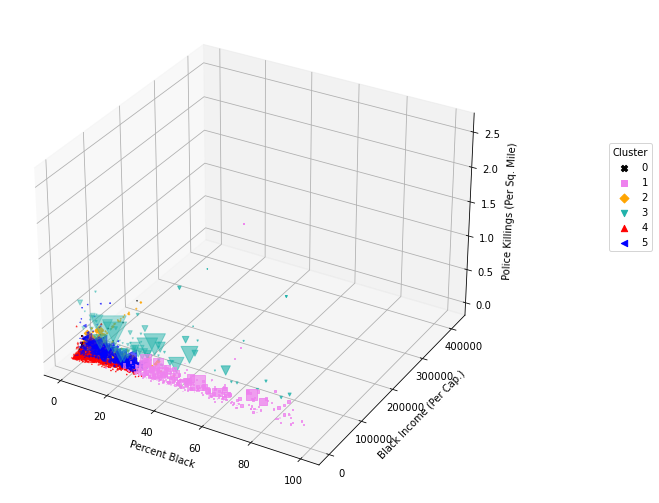

In [18]:
%matplotlib inline
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

for cluster_label, csub_cluster in csub_clusters:
    
    ax.scatter3D(
        xs=csub_cluster['BlackPopPerc'],#.clip(upper=0.6), 
        ys=csub_cluster['BlackPerCap'],#.clip(upper=1.5), 
        zs=csub_cluster['PKPerSqMile'],
        s=(csub_cluster['Adopters']**1/2),
        marker=markers[cluster_label],
        c=colors[cluster_label],
        label=cluster_label
    )
    
ax.set_xlabel('Percent Black')
ax.set_ylabel('Black Income (Per Cap.)')
ax.set_zlabel('Police Killings (Per Sq. Mile)')

lgnd = ax.legend(loc=(1.23,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

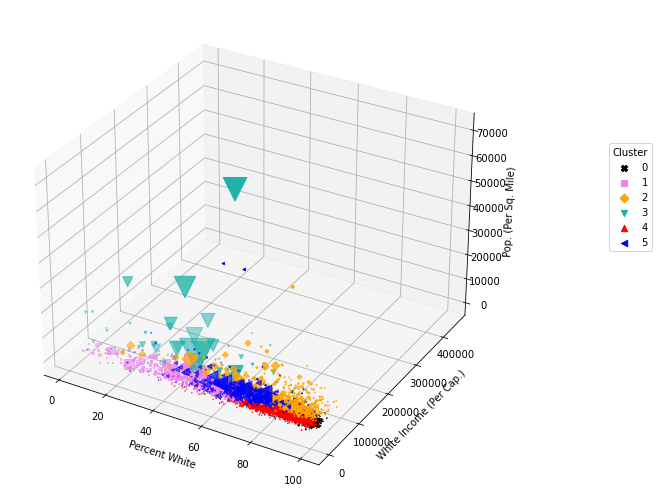

In [19]:
%matplotlib inline
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

for cluster_label, csub_cluster in csub_clusters:
    
    ax.scatter3D(
        xs=csub_cluster['WhitePopPerc'],#.clip(upper=0.6), 
        ys=csub_cluster['WhitePerCap'],#.clip(upper=1.5), 
        zs=csub_cluster['Pop_Dens'],
        s=(csub_cluster['Adopters']**1/2),
        marker=markers[cluster_label],
        c=colors[cluster_label],
        label=cluster_label
    )
    
ax.set_xlabel('Percent White')
ax.set_ylabel('White Income (Per Cap.)')
ax.set_zlabel('Pop. (Per Sq. Mile)')

lgnd = ax.legend(loc=(1.23,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

### View standardized distributions in 3D

Show 3D along 3 dimensions (% Black, Black Income, Police Killings):

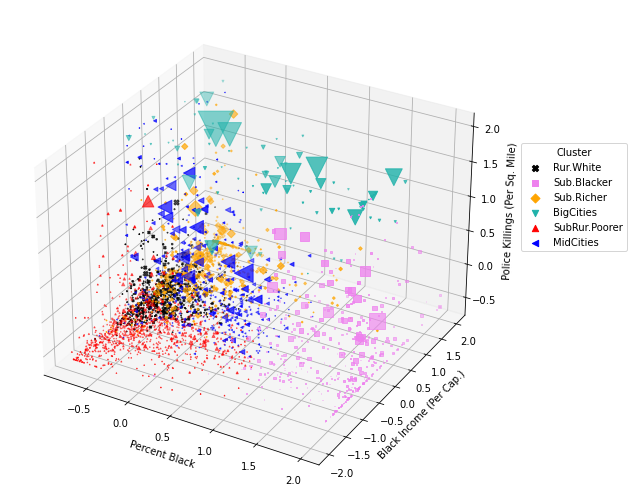

In [20]:
%matplotlib inline
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

for cluster_label, csub_cluster in csub_clusters:

    ax.scatter3D(
        xs=csub_cluster['BlackPopPerc_std'].clip(lower=-2.0, upper=2.0),
        ys=csub_cluster['BlackPerCap_std'].clip(lower=-2.0, upper=2.0),
        zs=csub_cluster['PKPerSqMile_std'].clip(lower=-2.0, upper=2.0), 
        s=(csub_cluster['Adopters']**1/2),
        c=colors[cluster_label],
        marker=markers[cluster_label],
        label=labels[cluster_label]
    )
    
ax.set_xlabel('Percent Black')
ax.set_ylabel('Black Income (Per Cap.)')
ax.set_zlabel('Police Killings (Per Sq. Mile)')

lgnd = ax.legend(loc=(1.05,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

Show 3D along other 3 dimensions:

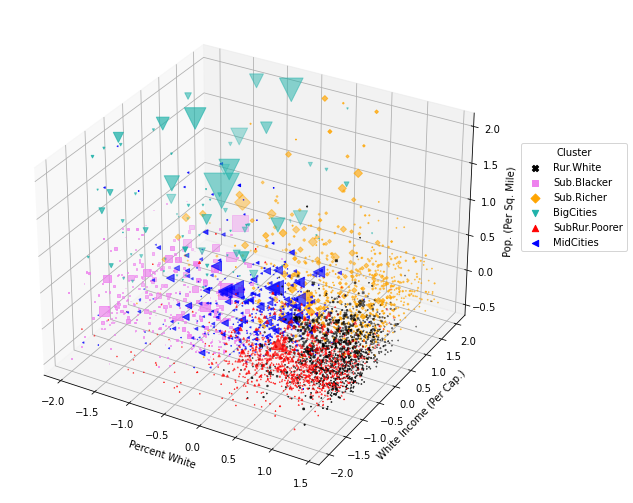

In [21]:
%matplotlib inline
# Then plot!

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

for cluster_label, csub_cluster in csub_clusters:
    
    ax.scatter3D(
        xs=csub_cluster['WhitePopPerc_std'].clip(lower=-2.0, upper=2.0),#, 
        ys=csub_cluster['WhitePerCap_std'].clip(lower=-2.0, upper=2.0),#.clip(upper=1.5), 
        zs=csub_cluster['Pop_Dens_std'].clip(lower=-2.0, upper=2.0),
        s=(csub_cluster['Adopters']**1/2),
        marker=markers[cluster_label],
        c=colors[cluster_label],
        label=labels[cluster_label]
    )
    
ax.set_xlabel('Percent White')
ax.set_ylabel('White Income (Per Cap.)')
ax.set_zlabel('Pop. (Per Sq. Mile)')

lgnd = ax.legend(loc=(1.05,0.5), title="Cluster")
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

plt.show()

Show the actual counties with users:

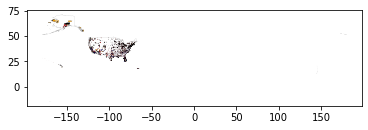

In [22]:
%matplotlib inline

fig, ax = plt.subplots(1, 1)

nation = gpd.read_file(f"utils/data_analysis/datasets/cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp")
nation.boundary.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=0.1
)
csubs_clusters_gdf = csubs_with_info_gdf.groupby(["cluster_label"])

for cluster_label, csubs_cluster_gdf in csubs_clusters_gdf:

    csubs_cluster_gdf.loc[csubs_cluster_gdf["Adopters"] > 0, :].plot(
        ax=ax,
        color=colors[cluster_label],
        edgecolor="black",
        linewidth=0.1
    )

## Construct Adopters DF

Because my edges_df is so huge, I load it in a function to ensure it gets garbage-collected as soon as I don't need it.

NOTE: Only need if you haven't defined adopters_df already.

In [23]:
def load_edges_dict():
    
    edges_df = load_edges_df()
    edges_df = edges_df.drop(["Type", "Weight"], axis=1)
    edges_df = edges_df.set_index('Source')
    edges_df = edges_df.groupby("Source").agg({
        "Target": lambda x: list(x)
    })
    
    edges_dict = edges_df.to_dict(orient='index')
    return edges_dict

In [24]:
def load_adopters_df():

    nbr_adopters = dict()
    exposures = dict()
    adopted = dict()
    
    edges_dict = load_edges_dict()
    print("Length of edges_dict:", len(edges_dict))

    with open(c.TWTS_CSV) as twts:

        reached_end = False
        i = 0

        while not reached_end:

            tw_row = twts.readline()
            if not tw_row:
                reached_end = True      # boolean, to allow finishing downloading the final round before breaking.
                print("END OF FILE!")
                break

            tweet = tw_row.split(',', 4)
            author_id = tweet[1]
            timestamp = tweet[2]
            author_info = edges_dict.get(author_id, None)

            if author_info:
                author_neighbors = author_info['Target']
                for target in author_neighbors:
                    if (target not in adopted):

                        # Mantain a set for each user of who exposed them.
                        if (target not in nbr_adopters):
                            nbr_adopters[target] = set()
                        nbr_adopters[target].add(author_id)

                        exposures[target] = exposures.get(target, 0) + 1

            if author_id not in adopted:
                adopted[author_id] = timestamp

            i += 1
            if i % 1000000 == 0:
                print(f"i={i} processed.")

    print(len(exposures))
    print(len(adopted))   
    
    dSeries = []
    for key in nbr_adopters:
        dSeries.append((key, nbr_adopters[key]))

    nbr_adopters_df = pd.DataFrame(data=dSeries, columns=[c.U_ID, "Nbr Adopters"])
    nbr_adopters_df = nbr_adopters_df.set_index(c.U_ID)
    nbr_adopters_df
    
    exposures_df = pd.DataFrame.from_dict(exposures, orient="index", columns=["exposures"])
    adopters_df = pd.DataFrame.from_dict(adopted, orient="index", columns=["adopted_time"])

    adopters_df = adopters_df.join(exposures_df)
    adopters_df = adopters_df.join(nbr_adopters_df)
    print(adopters_df)
    print()
    adopters_df["Nbr Adopter Count"] = adopters_df["Nbr Adopters"].apply(lambda nbrs: len(nbrs) if isinstance(nbrs, set) else -1)
    adopters_df["adopted_time"] =  pd.to_datetime(adopters_df["adopted_time"])
    
    print(adopters_df.loc[adopters_df["exposures"].notna()])
    
    # Feather does not store a "non-default" index when you save so need to reset in order to save which user each row refers to. See issue [here](https://github.com/pandas-dev/pandas/issues/28208).
    adopters_df = adopters_df.reset_index()
    return adopters_df

In [25]:
try:
    adopters_df = feather.read_feather("utils/data_analysis/feathers/adopters_df.ftr")
    print("adopters_df is already saved; skipping save.")
except Exception as e:
    print("Confirmed no previous save of adopters_df. Saving now.")
    adopters_df = load_adopters_df()
    feather.write_feather(adopters_df, "utils/data_analysis/feathers/adopters_df.ftr")

adopters_df is already saved; skipping save.


In [ ]:
adopters_df

## EXAMINE ADOPTIONS BY STATE AND US REGION

 while not a network characteristic per se, this analysis is easier using the newly constructed adopters_DF

In [27]:
state_labels_df = pd.read_csv('utils/data_analysis/datasets/StateLabels.csv')
state_labels_df

,STATE_NAME,Geo_STATE,STATE_ABBR
0,Alabama,1,AL
1,Alaska,2,AK
2,Arizona,4,AZ
3,Arkansas,5,AR
4,California,6,CA
5,Colorado,8,CO
6,Connecticut,9,CT
7,Delaware,10,DE
8,District of Columbia,11,DC
9,Florida,12,FL


In [28]:
state_counts = geo_users_w_info_gdf.groupby(["Geo_STATE"]).agg({
    "U_ID": "count"
})
state_counts = state_counts.merge(state_labels_df, on="Geo_STATE")
state_counts.sort_values(by="U_ID", axis=0, ascending=False)

,Geo_STATE,U_ID,STATE_NAME,STATE_ABBR
4,6.0,6953,California,CA
32,36.0,3377,New York,NY
43,48.0,3027,Texas,TX
9,12.0,1896,Florida,FL
13,17.0,1368,Illinois,IL
10,13.0,1131,Georgia,GA
35,39.0,1098,Ohio,OH
38,42.0,1016,Pennsylvania,PA
47,53.0,874,Washington,WA
33,37.0,864,North Carolina,NC


In [29]:
region_labels_df = pd.read_csv('utils/data_analysis/datasets/RegionLabels.csv')
region_labels_df

,STATE_NAME,STATE_ABBR,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific
5,Colorado,CO,West,Mountain
6,Connecticut,CT,Northeast,New England
7,District of Columbia,DC,South,South Atlantic
8,Delaware,DE,South,South Atlantic
9,Florida,FL,South,South Atlantic


In [ ]:
geo_users_w_info_gdf = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(state_labels_df, on="Geo_STATE")
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(region_labels_df[["STATE_ABBR","Region", "Division"]], on="STATE_ABBR")
geo_users_w_info_gdf

In [31]:
adopters_df = feather.read_feather("utils/data_analysis/feathers/adopters_df.ftr")
adopters_df = adopters_df.set_index("index")   # feather doesn't support non-default indices, must be re-set on load.
adopters_df['adopted_time'] = adopters_df['adopted_time'].dt.tz_convert('US/Eastern')

geo_users_w_info_gdf = geo_users_w_info_gdf.merge(
    adopters_df, how="left", left_on="U_ID", right_index=True
)
geo_users_w_info_gdf.fillna({"Nbr Adopter Count": 0, "exposures": 0}, inplace=True)
geo_users_w_info_gdf.dtypes

U_ID                                         object
mean-mode dev.                              float64
geometry                                   geometry
Geo_FIPS                                    float64
Geo_QNAME                                    object
Geo_STATE                                   float64
Total_Pop                                   float64
Pop_Dens                                    float64
Land_Area                                   float64
WhitePop                                    float64
BlackPop                                    float64
OtherRacePop                                float64
WhitePopPerc                                float64
BlackPopPerc                                float64
OtherRacePopPerc                            float64
PctLatinoPop                                float64
WhitePerCap                                 float64
BlackPerCap                                 float64
LatinoPerCap                                float64
PerCap      

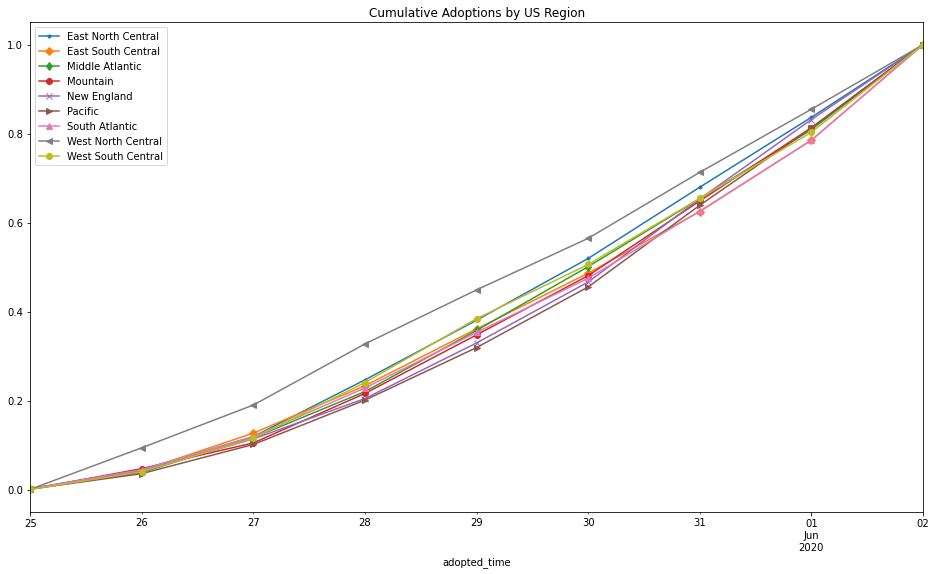

In [32]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

markers = ['.', 'D', 'd', 'o', 'x', '>', '^', '<', 'o', 'd', 'b', '.']
i = 0

for div, div_adopters in geo_users_w_info_gdf.groupby("Division"):
    
    div_counts = div_adopters.groupby(
        pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "U_ID": "count"
    })
    
    div_counts["U_ID"] = div_counts["U_ID"].cumsum()
    div_counts["U_ID"] = div_counts["U_ID"].div(div_counts["U_ID"].max())

    div_counts.plot(x=None, y="U_ID", use_index=True, label=div, ax=ax, marker=markers[i])
    i += 1
    
ax.set_title("Cumulative Adoptions by US Region")
ax.legend()


## Checking Within/Cross-Tie Ratio

The ratio of within-to-cross-ties is informative of both homophily as well as influence. Note that any sufficiently small minority will have a low within/cross-tie ratio, due to there only being a few of their peers with which to share ties, while superdominant majorities tend to have very high ratios.

In [33]:
def load_cluster_edges_df():

    cluster_edges_df = geo_edges_df.merge(
        geo_users_w_info_gdf[["U_ID","cluster_label"]],
        how="left",
        left_on="Target",
        right_on="U_ID"
    )

    cluster_edges_df.drop(columns=["U_ID"], inplace=True)
    cluster_edges_df.rename(columns={"cluster_label": "Target_Cluster"}, inplace=True)

    cluster_edges_df = cluster_edges_df.merge(
        geo_users_w_info_gdf[["U_ID","cluster_label"]],
        how="left",
        left_on="Source",
        right_on="U_ID"
    )

    cluster_edges_df.drop(columns=["U_ID"], inplace=True)
    cluster_edges_df.rename(columns={"cluster_label": "Source_Cluster"}, inplace=True)

    cluster_edges_df = cluster_edges_df.groupby(["Target_Cluster", "Source_Cluster"]).count()

    cluster_edges_df.drop(columns=["Source", "Type", "Weight"], inplace=True)
    cluster_edges_df.rename(columns={"Target": "Edges"}, inplace=True)

    cluster_edges_df.reset_index("Source_Cluster", inplace=True)
    
    return cluster_edges_df

def reformat_cluster_edges_df(cluster_edges_df):
    '''Making the cluster_edges_df a bit more readable!'''
    clusters = [i for i in range(0,6)]

    for cluster in clusters:
        cluster_edges_df.loc[:,cluster] = cluster_edges_df.loc[cluster_edges_df["Source_Cluster"]==cluster, "Edges"]

    cluster_edges_df.drop(columns=["Source_Cluster", "Edges"], inplace=True)

    cluster_edges_df["Total Edges"] = cluster_edges_df.sum(axis=1)
    cluster_edges_df = cluster_edges_df.groupby("Target_Cluster").first()
    
    return cluster_edges_df
    
load_cluster_edges_df()

,Source_Cluster,Edges
Target_Cluster,,
0.0,0.0,1421
0.0,1.0,1576
0.0,2.0,1811
0.0,3.0,5480
0.0,4.0,1115
0.0,5.0,2997
1.0,0.0,1365
1.0,1.0,6397
1.0,2.0,2330


Total Number of Edges Shared between Source_cluster (index) and Target_Cluster:

In [34]:
cluster_edges_df = load_cluster_edges_df()
cluster_edges_df = reformat_cluster_edges_df(cluster_edges_df)

pr_labels = [f"{label}={labels[label]}" for label in labels]
print("Cluster Labels:", " ".join(pr_labels))

cluster_edges_df

Cluster Labels: 0=Rur.White 1=Sub.Blacker 2=Sub.Richer 3=BigCities 4=SubRur.Poorer 5=MidCities


,0,1,2,3,4,5,Total Edges
Target_Cluster,,,,,,,
0.0,1421,1576,1811,5480,1115,2997,14400
1.0,1365,6397,2330,8462,1656,4566,24776
2.0,1543,2293,3785,10126,1404,4513,23664
3.0,2907,5190,6818,42385,2748,10013,70061
4.0,1091,1742,1552,5204,1728,3084,14401
5.0,2147,3806,3970,13654,2381,11483,37441


Same as Above, but as Percent of Overall Number of Edges from that Source Cluster:

In [35]:
cluster_edges_df = load_cluster_edges_df()
cluster_edges_df = reformat_cluster_edges_df(cluster_edges_df)

clusters = [i for i in range(0,6)]

for cluster in clusters:
    cluster_edges_df.loc[:,cluster] =cluster_edges_df.loc[:,cluster] / (cluster_edges_df.loc[:,"Total Edges"])

cluster_edges_df

,0,1,2,3,4,5,Total Edges
Target_Cluster,,,,,,,
0.0,0.098681,0.109444,0.125764,0.380556,0.077431,0.208125,14400
1.0,0.055094,0.258193,0.094043,0.341540,0.066839,0.184291,24776
2.0,0.065205,0.096898,0.159948,0.427907,0.059331,0.190712,23664
3.0,0.041492,0.074078,0.097315,0.604973,0.039223,0.142918,70061
4.0,0.075759,0.120964,0.107770,0.361364,0.119992,0.214152,14401
5.0,0.057344,0.101653,0.106033,0.364680,0.063593,0.306696,37441


The next table is a slight variation on the above. This time, tie ratios represented as a proportion of all *possible* ties between two clusters in a perfectly connected network. This accounts for variable sizes of groups.

In [36]:
cluster_edges_df = load_cluster_edges_df()
user_counts_df = users_clusters.agg({
    "U_ID": "count"
})
cluster_edges_df = cluster_edges_df.merge(
    user_counts_df,
    how="left",
    left_on="Source_Cluster",
    right_index=True
)
cluster_edges_df.rename(columns={"U_ID": "Source_Count"}, inplace=True)

cluster_edges_df = cluster_edges_df.merge(
    user_counts_df,
    how="left",
    left_index=True,
    right_index=True
)
cluster_edges_df.rename(columns={"U_ID": "Target_Count"}, inplace=True)
cluster_edges_df["Tie_Ratio"] = cluster_edges_df["Edges"] / ( cluster_edges_df["Source_Count"] * cluster_edges_df["Target_Count"])
cluster_edges_df.drop(columns=["Edges", "Source_Count", "Target_Count"], inplace=True)

for cluster in clusters:
    cluster_edges_df.loc[:,cluster] = cluster_edges_df.loc[cluster_edges_df["Source_Cluster"]==cluster, "Tie_Ratio"]

        
cluster_edges_df.drop(columns=["Source_Cluster", "Tie_Ratio"], inplace=True)
cluster_edges_df = cluster_edges_df.groupby(level=0).first()

pr_labels = [f"{label}={labels[label]}" for label in labels]
print("Labels:", " ".join(pr_labels))

cluster_edges_df

Labels: 0=Rur.White 1=Sub.Blacker 2=Sub.Richer 3=BigCities 4=SubRur.Poorer 5=MidCities


,0,1,2,3,4,5
0.0,0.000141,0.000101,0.000126,0.000164,0.000102,0.000120
1.0,0.000087,0.000264,0.000104,0.000164,0.000098,0.000118
2.0,0.000107,0.000103,0.000184,0.000213,0.000090,0.000127
3.0,0.000087,0.000101,0.000144,0.000386,0.000076,0.000122
4.0,0.000100,0.000103,0.000100,0.000145,0.000147,0.000115
5.0,0.000086,0.000099,0.000112,0.000166,0.000089,0.000187


## Calculate Instigators, Adopters w/ 2+ Peers

Instigators are defined as those users who have adopted #BlackLivesMatter Without any prior exposures on their Twitter network. Looking at the rate of instigators, as opposed to the rate of a doctors with two or more peers, can provide a sense of the saturation of the network, as well as an ability to infer the amount of off-line influence.

First, let me merge my detailed geo_users gdf with my exposures information.

In [37]:
geo_users_w_info_gdf = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(state_labels_df, on="Geo_STATE")
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(region_labels_df[["STATE_ABBR","Region", "Division"]], on="STATE_ABBR")
geo_users_w_info_gdf.index = geo_users_w_info_gdf.index.astype(int)

In [38]:
geo_users_w_info_gdf = geo_users_w_info_gdf.merge(
    adopters_df, how="left", left_on="U_ID", right_index=True
)
geo_users_w_info_gdf.fillna({"Nbr Adopter Count": 0, "exposures": 0}, inplace=True)
geo_users_w_info_gdf.dtypes

U_ID                                         object
mean-mode dev.                              float64
geometry                                   geometry
Geo_FIPS                                    float64
Geo_QNAME                                    object
Geo_STATE                                   float64
Total_Pop                                   float64
Pop_Dens                                    float64
Land_Area                                   float64
WhitePop                                    float64
BlackPop                                    float64
OtherRacePop                                float64
WhitePopPerc                                float64
BlackPopPerc                                float64
OtherRacePopPerc                            float64
PctLatinoPop                                float64
WhitePerCap                                 float64
BlackPerCap                                 float64
LatinoPerCap                                float64
PerCap      

In [ ]:
adopters_clusters = geo_users_w_info_gdf.groupby(["cluster_label"])
adopters_clusters

                adopted_time  U_ID  AdopPerCap
33 2020-06-02 18:00:00-04:00  3177    0.000038
                adopted_time  U_ID  AdopPerCap
35 2020-06-02 18:00:00-04:00  4912    0.000128
                adopted_time  U_ID  AdopPerCap
34 2020-06-02 18:00:00-04:00  4532     0.00009
                adopted_time   U_ID  AdopPerCap
35 2020-06-02 18:00:00-04:00  10483    0.000374
                adopted_time  U_ID  AdopPerCap
32 2020-06-02 18:00:00-04:00  3308    0.000052
                adopted_time  U_ID  AdopPerCap
35 2020-06-02 18:00:00-04:00  7816    0.000122


Text(0.5, 0, 'Time')

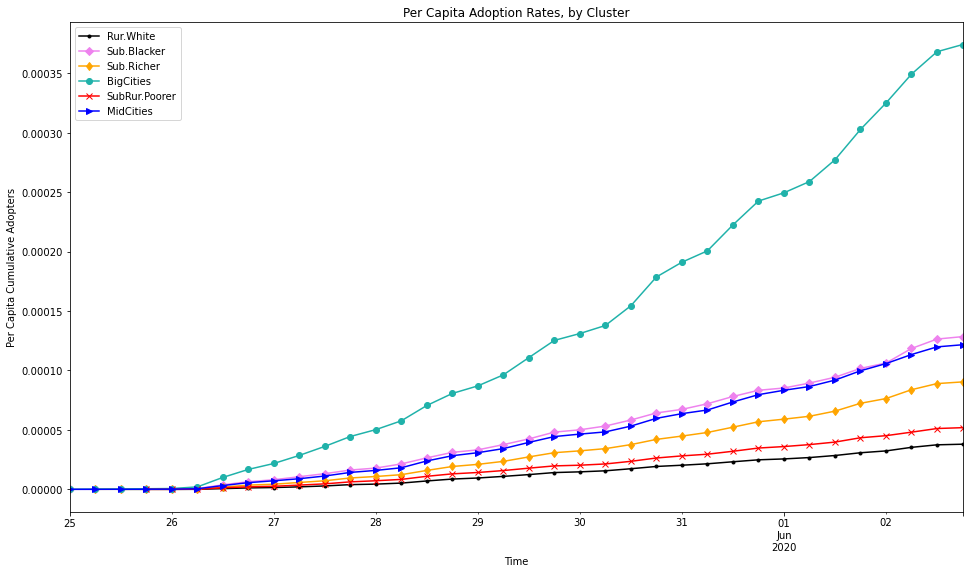

In [40]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.set_title("Per Capita Adoption Rates, by Cluster")
ax.set_ylabel("Per Capita Cumulative Adopters")

clusters_by_pd = []

for label, cluster in adopters_clusters:

    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='6h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"].cumsum()
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / pop_and_adopt.loc[label, 'Total_Pop']
    
    clusters_by_pd.append((label, cluster_by_pd))
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
    print(cluster_by_pd.tail(1))
    
ax.legend()
ax.set_xlabel("Time")

In [41]:
from functools import reduce

merge = []

for label, cluster_by_pd in clusters_by_pd:
    
    cluster_by_pd = cluster_by_pd.loc[:,["adopted_time","AdopPerCap"]]
    cluster_by_pd.rename(columns={"AdopPerCap": labels[label]}, inplace=True)
    merge.append(cluster_by_pd)
    
df_merged = reduce(lambda  left,right: pd.merge(left,right,on='adopted_time',
                                            how='left'), merge)
df_merged

,adopted_time,Rur.White,Sub.Blacker,Sub.Richer,BigCities,SubRur.Poorer,MidCities
0,2020-05-25 12:00:00-04:00,1.195770e-08,1.830701e-07,7.977908e-08,3.211768e-07,NaN,7.781518e-08
1,2020-05-25 18:00:00-04:00,1.195770e-08,2.615287e-07,7.977908e-08,5.352946e-07,1.568968e-08,1.400673e-07
2,2020-05-26 00:00:00-04:00,1.195770e-08,2.615287e-07,9.972385e-08,7.137262e-07,1.568968e-08,1.711934e-07
3,2020-05-26 06:00:00-04:00,4.783079e-08,6.538219e-07,3.590059e-07,2.069806e-06,1.255174e-07,5.135802e-07
4,2020-05-26 12:00:00-04:00,6.337580e-07,3.792167e-06,1.894753e-06,1.002785e-05,1.365002e-06,3.205985e-06
5,2020-05-26 18:00:00-04:00,1.231643e-06,6.433607e-06,3.570114e-06,1.677256e-05,2.102417e-06,5.649382e-06
6,2020-05-27 00:00:00-04:00,1.554501e-06,8.081238e-06,4.328015e-06,2.176865e-05,2.604487e-06,7.205685e-06
7,2020-05-27 06:00:00-04:00,2.116513e-06,1.064422e-05,5.803928e-06,2.854905e-05,3.592937e-06,8.964308e-06
8,2020-05-27 12:00:00-04:00,2.881805e-06,1.320720e-05,7.239952e-06,3.615023e-05,4.644145e-06,1.123651e-05
9,2020-05-27 18:00:00-04:00,3.993871e-06,1.626709e-05,9.593434e-06,4.446514e-05,6.322941e-06,1.427130e-05


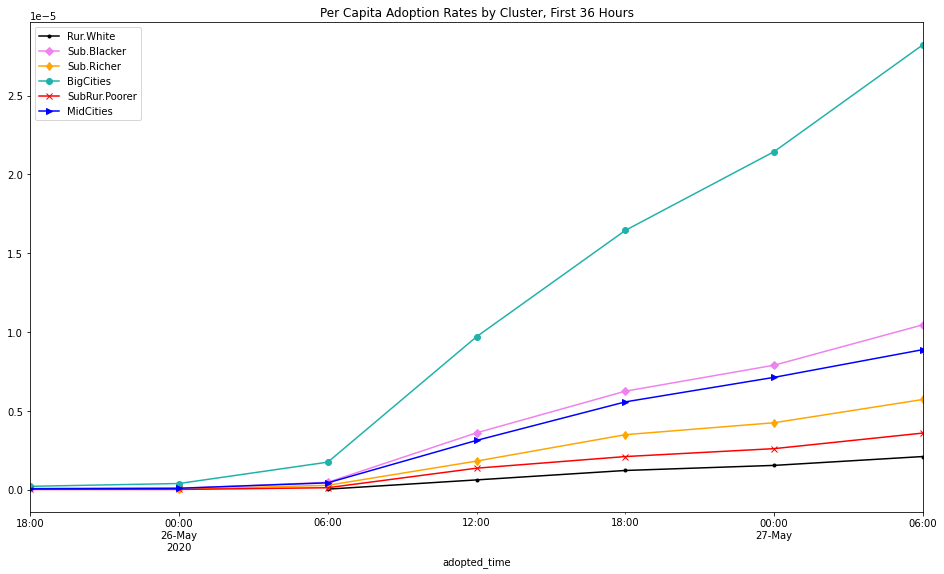

In [42]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

total_adopters_clusters = []

ax.set_title("Per Capita Adoption Rates by Cluster, First 36 Hours")

for label, cluster in adopters_clusters:
    
    cluster = cluster.loc[cluster["adopted_time"] > "2020-05-25 18:00:00"]
    cluster = cluster.loc[cluster["adopted_time"] < "2020-05-27 12:00:00"]
    
    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='6h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    total_adopters = cluster_by_pd["U_ID"].sum()
    
    
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"].cumsum()
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / pop_and_adopt.loc[label, 'Total_Pop']
    
    total_adopters_clusters.append(total_adopters)
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
ax.legend()

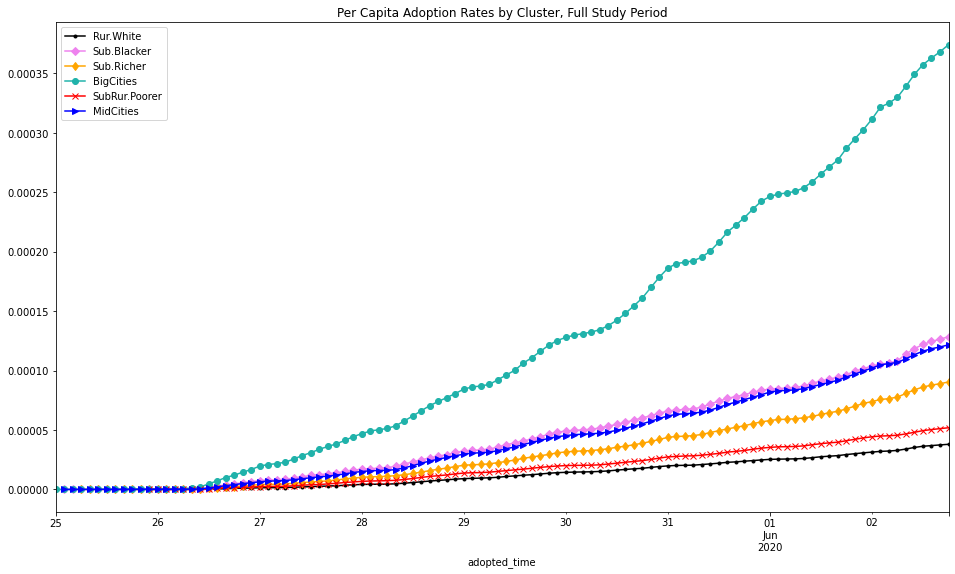

In [43]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

total_adopters_clusters = []

ax.set_title("Per Capita Adoption Rates by Cluster, Full Study Period")

for label, cluster in adopters_clusters:

    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='2h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    total_adopters = cluster_by_pd["U_ID"].sum()
    
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"].cumsum()
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / pop_and_adopt.loc[label, 'Total_Pop']
    
    total_adopters_clusters.append(total_adopters)
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
ax.legend()

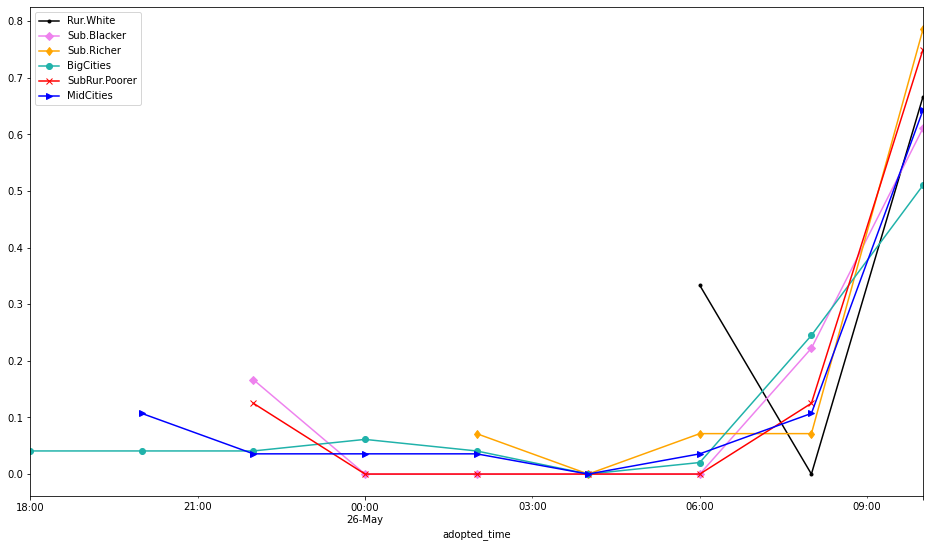

In [44]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

for label, cluster in adopters_clusters:
    cluster = cluster.loc[cluster["adopted_time"] > "2020-05-25 18:00:00"]
    cluster = cluster.loc[cluster["adopted_time"] < "2020-05-26 12:00:00"]
    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='2h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"]
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / cluster_by_pd["U_ID"].sum()
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
ax.legend()

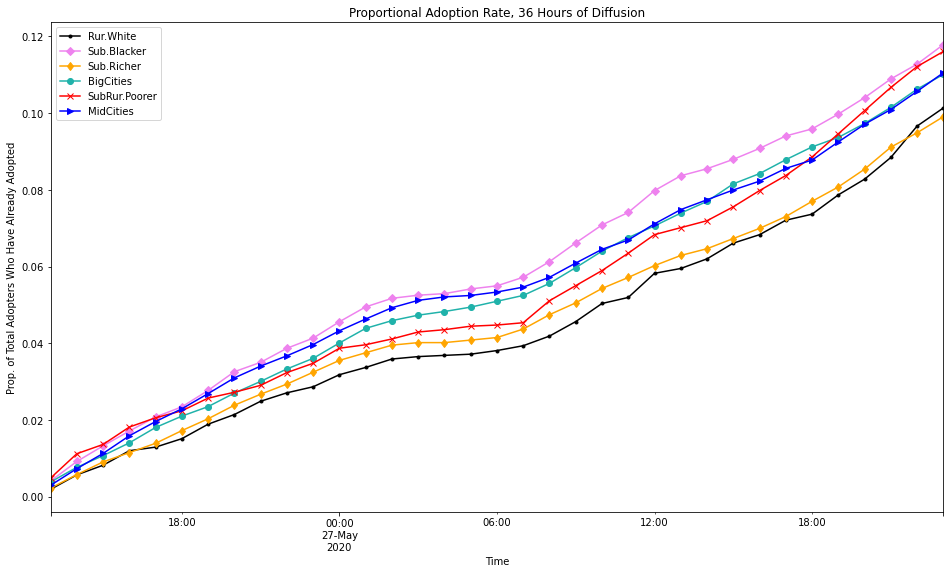

In [45]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(16,9))

for label, cluster in adopters_clusters:
    
    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='1h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    total_adopters = cluster_by_pd["U_ID"].sum()
    
    cluster_by_pd = cluster_by_pd.loc[cluster_by_pd["adopted_time"] > "2020-05-26 12:00:00"]
    cluster_by_pd = cluster_by_pd.loc[cluster_by_pd["adopted_time"] < "2020-05-28 00:00:00"]
    
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"].cumsum()
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / total_adopters
    
    total_adopters_clusters.append(total_adopters)
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
ax.set_title("Proportional Adoption Rate, 36 Hours of Diffusion")
ax.set_ylabel("Prop. of Total Adopters Who Have Already Adopted")
ax.set_xlabel("Time")
ax.legend()

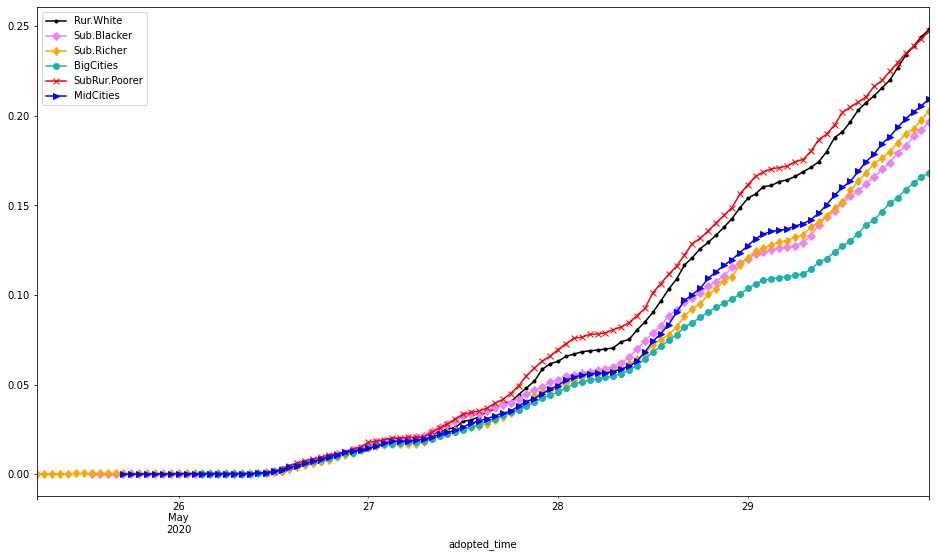

In [46]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

for label, cluster in adopters_clusters:
    
    cluster_to_plt = cluster.loc[cluster["adopted_time"] < "2020-05-30"]
    
    cluster_by_pd = cluster_to_plt[~cluster_to_plt["prior_adopter"]].groupby(
        pd.Grouper(key="adopted_time", freq='h')
    ).agg({
        "U_ID": "count"
    })
    cluster_by_pd.reset_index(inplace=True)
    cluster_by_pd["U_ID"] = cluster_by_pd["U_ID"].cumsum()
    cluster_by_pd["AdopPerCap"] = cluster_by_pd["U_ID"] / total_adopters_clusters[label]
    
    cluster_by_pd.plot(
        x="adopted_time", 
        y="AdopPerCap", 
        ax=ax, 
        use_index=True, 
        c=colors[label], 
        marker=markers[label],
        label=labels[label]
    )
    
ax.legend()

Text(0.5, 1.0, 'Reinforcement Ratio (4+) by Day')

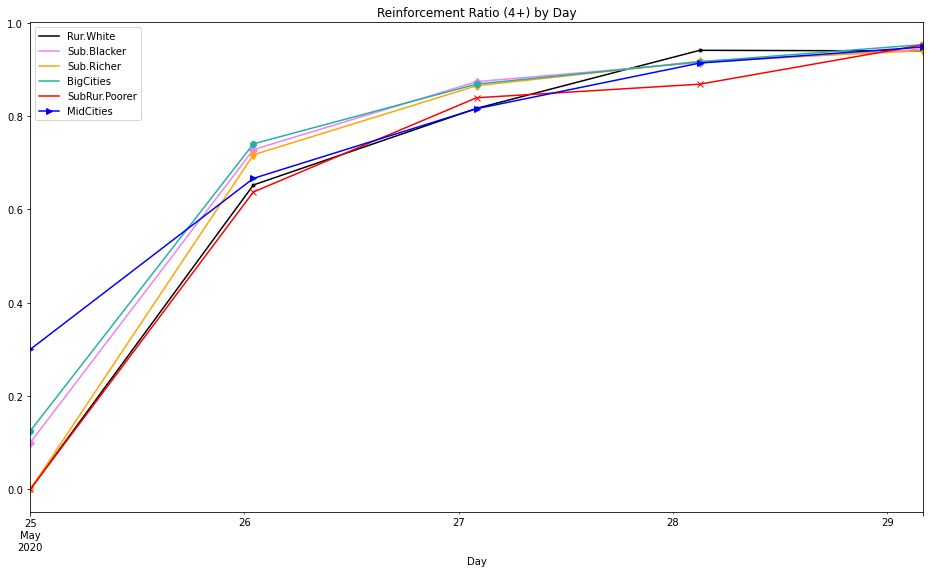

In [47]:
%matplotlib inline

clusters_inst_ratios = []
clusters_reinf_ratios = []
fig, ax = plt.subplots(1,1, figsize=(16,9))

for cluster_label, cluster in adopters_clusters:
    cluster_filt = cluster[cluster["adopted_time"] > "2020-05-25"]
    cluster_filt = cluster_filt[cluster_filt["adopted_time"] < "2020-05-30"]
    cluster_by_pd = cluster_filt.groupby(
        pd.Grouper(key="adopted_time", freq='25h')
    )
    dSeries = []
        
    for day, cluster_pd in cluster_by_pd:
        instigator_ratio = cluster_pd["Nbr Adopter Count"].loc[lambda x:x<3].count() / cluster_pd["Nbr Adopter Count"].count()
        reinforce_ratio = cluster_pd["Nbr Adopter Count"].loc[lambda x:x>3].count() / cluster_pd["Nbr Adopter Count"].count()
        if not math.isnan(instigator_ratio):                
            dSeries.append((day, instigator_ratio, reinforce_ratio))
            
    expos_stats_df = pd.DataFrame.from_dict(dSeries)
    expos_stats_df.columns = ["Day", "Instigator Ratio", "Reinforce. Ratio"]
    expos_stats_df.plot(
        x="Day", 
        y="Reinforce. Ratio", 
        use_index=True, 
        c=colors[cluster_label], 
        marker=markers[cluster_label],
        ax=ax, 
        label=labels[cluster_label]
    )
    
ax.set_title("Reinforcement Ratio (4+) by Day")


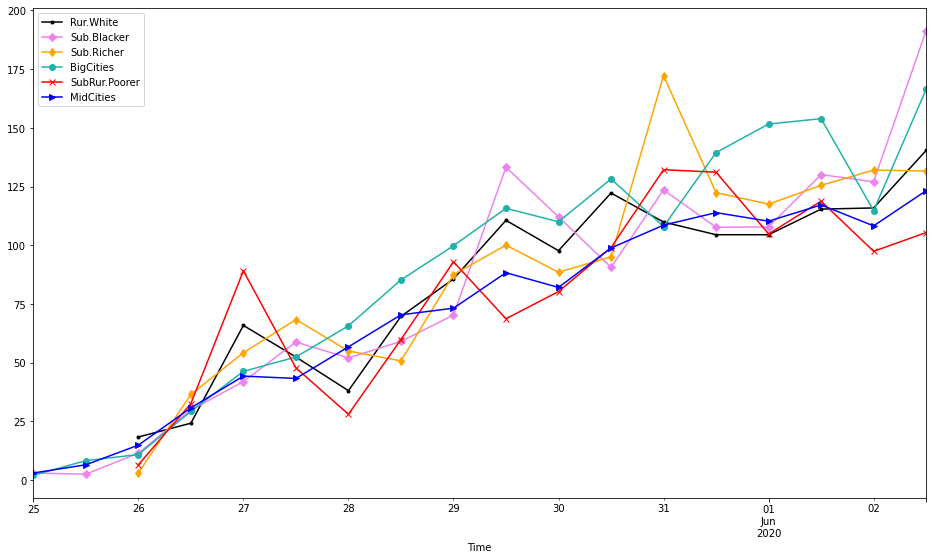

In [48]:
### %matplotlib inline

clusters_inst_ratios = []
clusters_reinf_ratios = []
fig, ax = plt.subplots(1,1, figsize=(16,9))

for cluster_label, cluster in adopters_clusters:
    cluster_by_pd = cluster.groupby(
        pd.Grouper(key="adopted_time", freq='12h')
    )
    dSeries = []
        
    for time_pd, cluster_pd in cluster_by_pd:
        
        cluster_pd = cluster_pd.loc[cluster_pd["Nbr Adopter Count"] >= 0]
        med_nbr_ratio = cluster_pd["Nbr Adopter Count"].mean()# / cluster_pd["Following"].mean()
        dSeries.append((time_pd, med_nbr_ratio))
            
    med_nbr_df = pd.DataFrame.from_dict(dSeries)
    med_nbr_df.columns = ["Time", "Median Adopting Neighbors"]
    
    med_nbr_df.plot(
        x="Time", 
        y="Median Adopting Neighbors", 
        ax=ax,
        c=colors[cluster_label],
        label=labels[cluster_label],
        marker=markers[cluster_label]
    )

ax.legend()


## Tie Ratio

Tie_Ratio(m) = 1 / m*(m-1) [for all pairs of users in first m adoptions]

In [49]:
def calc_ratios(subpop_twts_df, geo_edges_df, m_min=10, m_max=150, m_spacing=10):

    tie_ratios = []

    for m in range(m_min, m_max, m_spacing):

        users = subpop_twts_df.head(m)
        
        sub_edges_df = geo_edges_df.loc[geo_edges_df["Source"].isin(users[c.U_ID])]
        sub_edges_df = sub_edges_df.loc[sub_edges_df["Target"].isin(users[c.U_ID])]
        
        num_ties = len(sub_edges_df)

        tie_ratio = num_ties/(m*(m-1))
        tie_ratios.append((m, tie_ratio))

    return tie_ratios

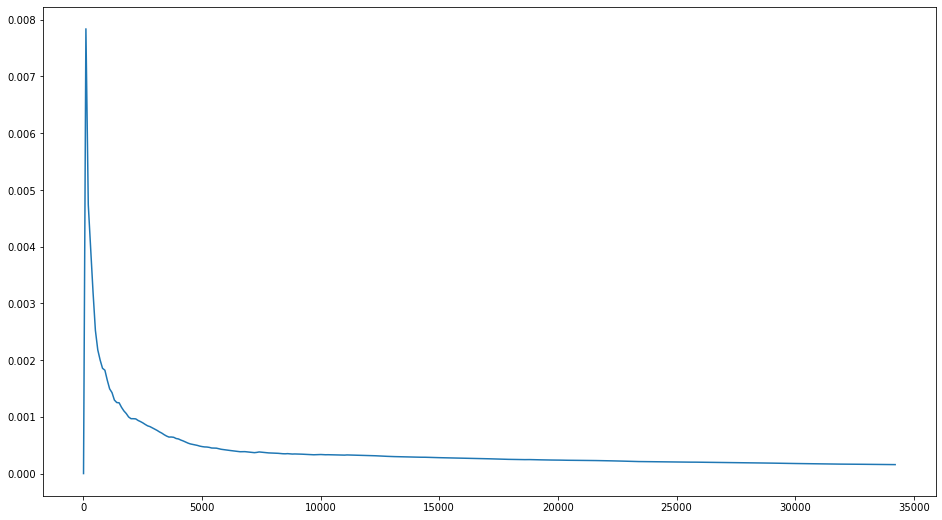

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

tie_ratios = calc_ratios(
    geo_users_w_info_gdf.sort_values(by="adopted_time"), 
    geo_edges_df,
    m_min=10, m_max=len(geo_users_w_info_gdf), m_spacing=100
)
    
ax.plot([pt[0] for pt in tie_ratios], [pt[1] for pt in tie_ratios])

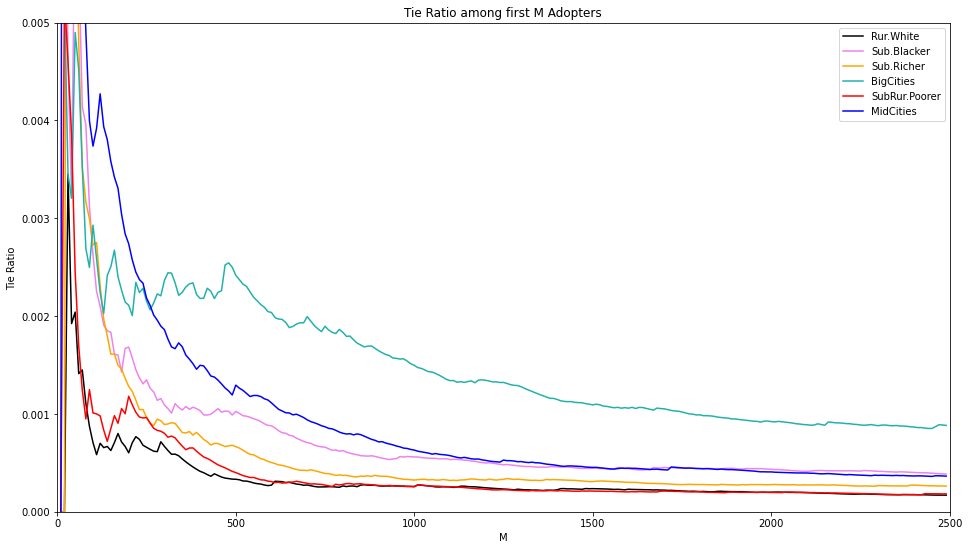

In [51]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.set_title("Tie Ratio among first M Adopters")
ax.set_xlabel("M")
ax.set_ylabel("Tie Ratio")
    
for label, cluster in adopters_clusters:
    # print(cluster)
    tie_ratios = calc_ratios(
        cluster.sort_values(by="adopted_time"), 
        geo_edges_df,
        m_max=2500,
    )
    
    ax.plot(
        [pt[0] for pt in tie_ratios], 
        [pt[1] for pt in tie_ratios], 
        c=colors[label],
        label=labels[label]
    )
    
ax.set_xlim(left=-1, right=2500)
ax.set_ylim(bottom=0.000, top=0.005)
ax.legend()

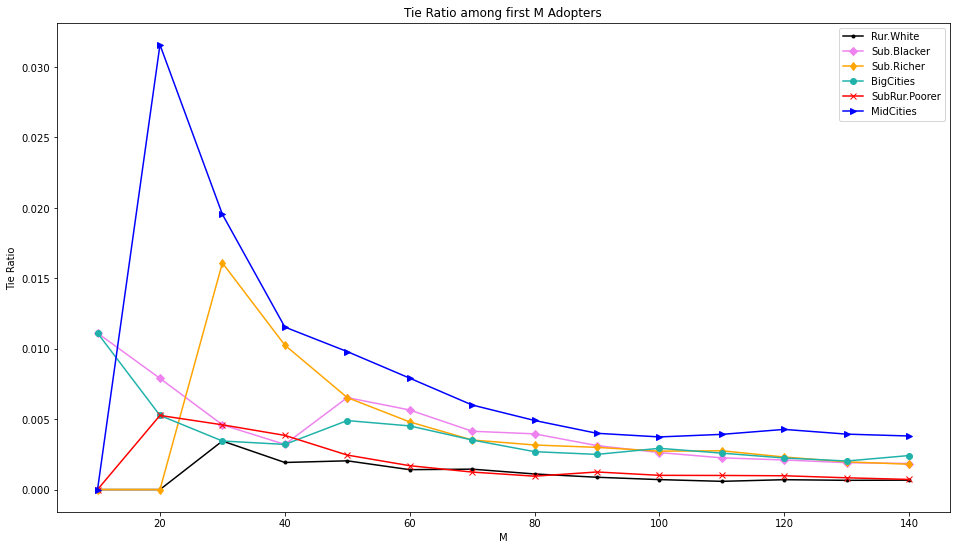

In [52]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.set_title("Tie Ratio among first M Adopters")
ax.set_xlabel("M")
ax.set_ylabel("Tie Ratio")
    
for label, cluster in adopters_clusters:
    # print(cluster)
    tie_ratios = calc_ratios(
        cluster.sort_values(by="adopted_time"), 
        geo_edges_df,
        m_max=150,
        m_spacing=10
    )
    
    ax.plot(
        [pt[0] for pt in tie_ratios], 
        [pt[1] for pt in tie_ratios], 
        c=colors[label],
        label=labels[label],
        marker=markers[label]
    )
    
ax.legend()

## Daily Overlap

Mean overlap is a metric defined in “Complex Contagions and the Diffusion of Popular Twitter Hashtags in Nigeria.” Fink et al. (2015).

Like within-group tie ratio, it helps measure network density; however, instead of measuring the density of ties among those who have already adopted, it looks at the density of ties among the neighbor-adopters for each adopter at a given time. To calculate mean overlap, for each first-time adopter in a given time period, you calculate the within-group tie ratio among just the first-time adopter’s neighbors who have already adopted, and then calculate the mean of all such tie ratios.

Mean overlap is expected to drop rapidly following a period with a low adoption rate and during a period with a rapidly increasing adoption rate, in scenarios in which a contagion is complex.

In [53]:
def calc_overlap(adopters_df, geo_edges_df, time_freq='12h'):
    
    adopters_by_day_df = adopters_df.groupby(
        pd.Grouper(key="adopted_time", freq=time_freq)
    )
    mean_overlaps = []
    
    for label, adopters_day_df in adopters_by_day_df:

        adopters_day_df = adopters_day_df.set_index("U_ID")

        overlaps = []    
        for user in adopters_day_df.index:
            
            # First, get all of their geotagged sources.
            nbr_geo_adopters = set(geo_edges_df.loc[geo_edges_df["Target"]==user, "Source"])
            
            # Get the list of all (geo- and nongeo-) users they follow who adopted before them.
            nbr_prior_adopters = adopters_day_df.loc[user, "Nbr Adopters"]
            
            if (nbr_prior_adopters is not None):
                
                # Get all the geo-adopters who adopted prior.
                nbr_prior_adopters = set(nbr_prior_adopters) # convert from nd.array
                nbr_prior_geo_adopters = (nbr_geo_adopters & nbr_prior_adopters)
                
                if len(nbr_prior_geo_adopters) > 1:
            
                    sub_edges_df = geo_edges_df.loc[geo_edges_df["Source"].isin(nbr_prior_geo_adopters)]
                    sub_edges_df = sub_edges_df.loc[sub_edges_df["Target"].isin(nbr_prior_geo_adopters)]

                    num_ties = len(sub_edges_df)
                    overlap = num_ties / (len(nbr_prior_geo_adopters)*(len(nbr_prior_geo_adopters)-1))

                    overlaps.append(overlap)
            
        if len(overlaps) > 0:
            mean_overlaps.append((label, np.mean(overlaps))) 
            
    return mean_overlaps

In [54]:
mean_overlaps = calc_overlap(geo_users_w_info_gdf, geo_edges_df)

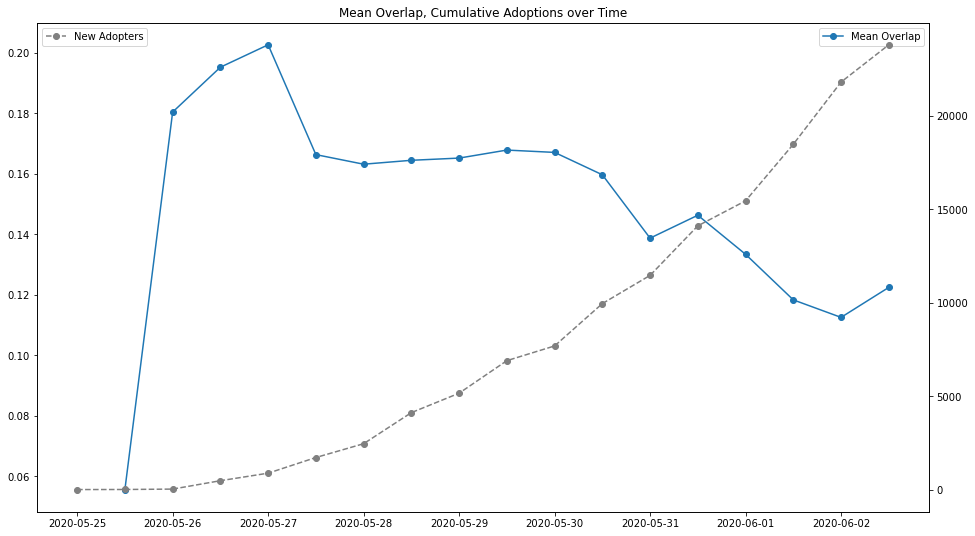

In [55]:
%matplotlib inline 
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.plot([pt[0] for pt in mean_overlaps], [pt[1] for pt in mean_overlaps], label="Mean Overlap", marker="o")

new_users_adopted = geo_users_w_info_gdf[~geo_users_w_info_gdf["prior_adopter"]].groupby(
        pd.Grouper(key="adopted_time", freq='12h')
).agg({
    "U_ID": "count"
})
new_users_adopted["U_ID"] = new_users_adopted["U_ID"].cumsum()
new_users_adopted.reset_index(inplace=True)

ax2 = ax.twinx()
ax2.plot(
    new_users_adopted["adopted_time"], 
    new_users_adopted["U_ID"], 
    color="grey", 
    linestyle="dashed",
    label="New Adopters",
    marker="o"
)

ax.set_title("Mean Overlap, Cumulative Adoptions over Time")
ax.legend()
ax2.legend()

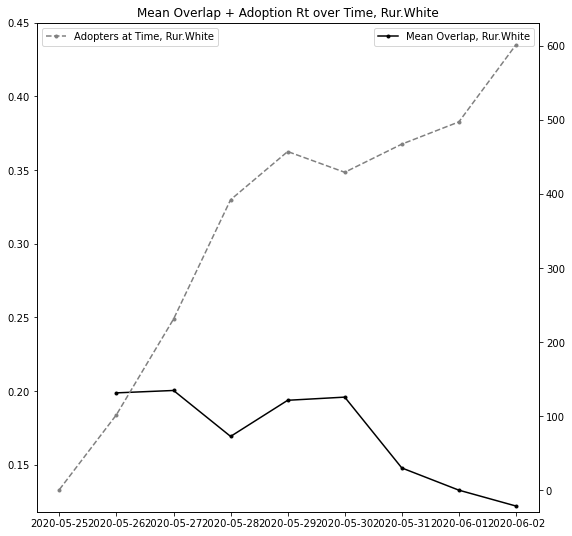

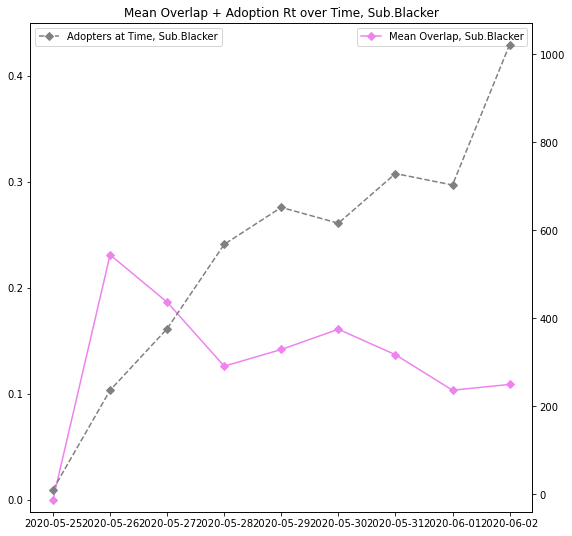

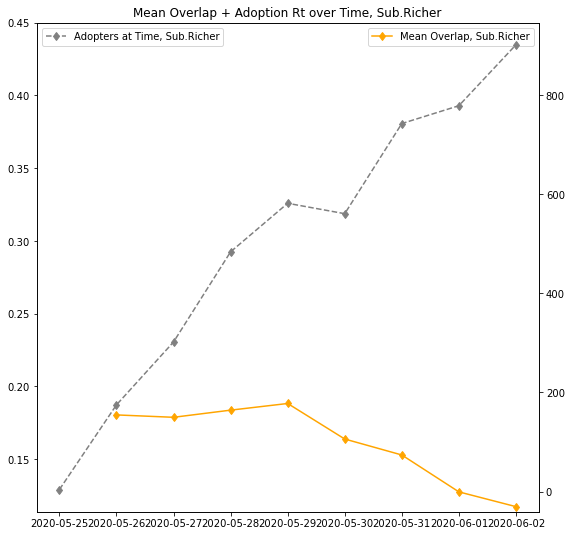

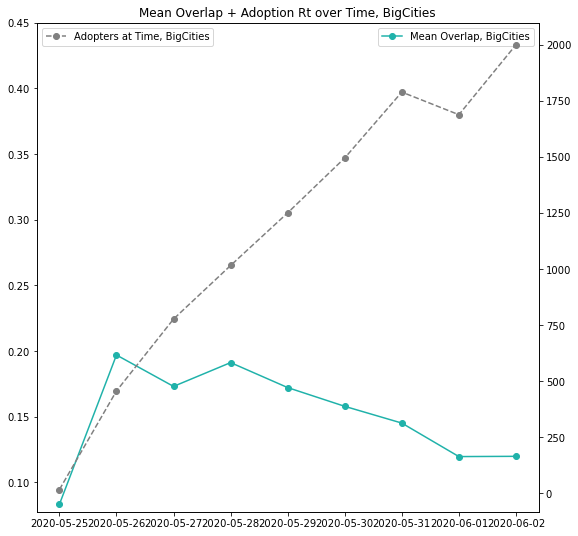

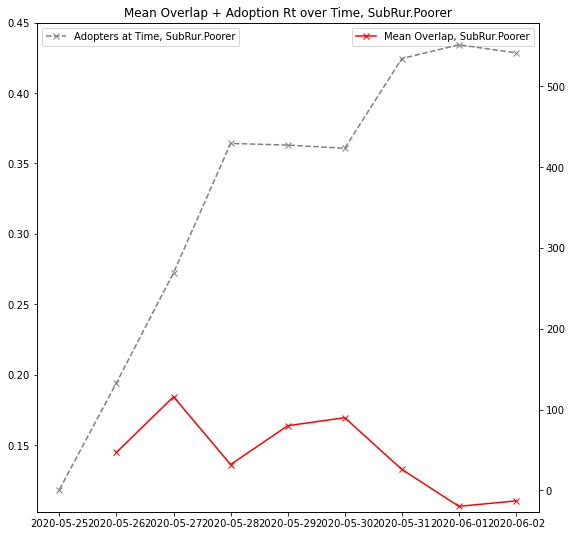

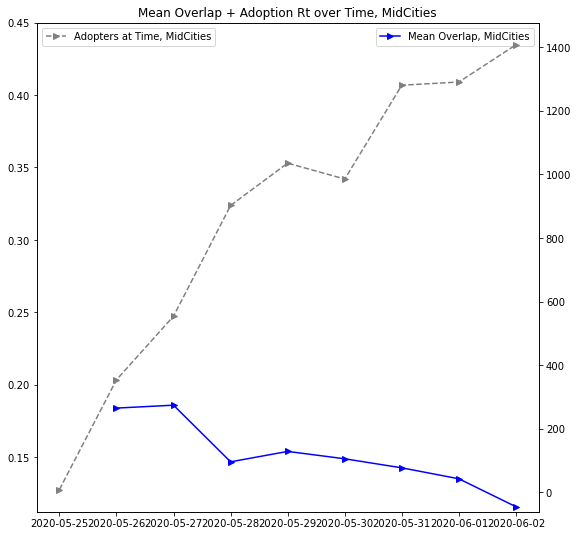

In [56]:
%matplotlib inline 

for label, cluster in adopters_clusters:
    mean_overlaps = calc_overlap(cluster, geo_edges_df, time_freq='24h')
    fig, ax = plt.subplots(1,1, figsize=(9,9))

    ax.plot(
        [pt[0] for pt in mean_overlaps], 
        [pt[1] for pt in mean_overlaps], 
        label=f"Mean Overlap, {labels[label]}",
        color=colors[label],
        marker=markers[label],
    )
    ax.set_ylim(top=0.45)

    new_users_adopted = cluster.groupby(
            pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "U_ID": "count"
    })
    new_users_adopted.reset_index(inplace=True)

    ax2 = ax.twinx()
    ax2.plot(
        new_users_adopted["adopted_time"], 
        new_users_adopted["U_ID"], 
        color="grey",
        marker=markers[label],
        linestyle="dashed",
        label=f"Adopters at Time, {labels[label]}"
    )

    ax.legend()
    ax2.legend()
    ax2.set_title(f"Mean Overlap + Adoption Rt over Time, {labels[label]}")
    
    plt.show()


## Geographic Distribution of Adopters by Cluster + Day

In [57]:
county_subd_gdf = gpd.read_file("utils/data_analysis/datasets/county_subdivs/COUSUB_2019_US_SL060_Coast_Clipped.dbf")

In [58]:
%matplotlib qt

geo_users_w_info_gdf["adopted_time_since"] = geo_users_w_info_gdf["adopted_time"] - pd.to_datetime("2020-05-25").tz_localize('US/Eastern')
geo_users_w_info_gdf["adopted_time_since"] = geo_users_w_info_gdf["adopted_time_since"] / pd.Timedelta(hours=1)

geos_c = geo_users_w_info_gdf.groupby(["Geo_FIPS"]).agg({
    "adopted_time_since": "median",
    "U_ID": "count"
})
geos_c.reset_index(inplace=True)

geos_c["Geo_FIPS"] = geos_c["Geo_FIPS"].astype(int)
county_subd_gdf["Geo_FIPS"] = county_subd_gdf["Geo_FIPS"].astype(int)

subd_med_time_gdf = county_subd_gdf.merge(
    geos_c, 
    how="left",
    on="Geo_FIPS", 
)
subd_med_time_gdf = subd_med_time_gdf.loc[subd_med_time_gdf["U_ID"].notna(), :]


fig, ax = plt.subplots(1, 1)
subd_med_time_gdf.plot(
    column="adopted_time_since",
    ax=ax,
    legend=True
)
county_subd_gdf.boundary.plot(
    ax=ax,
)


<AxesSubplot:>

In [61]:
%matplotlib qt
plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(1, 1)

labels_df = geo_users_w_info_gdf.groupby(["Geo_FIPS"]).agg({
    "cluster_label": "first"
}) 
labels_df.reset_index(inplace=True)
labels_df["Geo_FIPS"] = labels_df["Geo_FIPS"].astype(int)
county_subd_gdf["Geo_FIPS"] = county_subd_gdf["Geo_FIPS"].astype(int)

csubs_w_label = county_subd_gdf.merge(
    labels_df, 
    how="left",
    on="Geo_FIPS", 
)




csubs_w_label.plot(
    ax=ax,
    legend=True,
    column="cluster_label",
    cmap='nipy_spectral',
)
county_subd_gdf.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=0.25,
)

<AxesSubplot:>

In [62]:
csubs_w_label.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,Geo_FIPS,NAME,Geo_QNAME,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cluster_label
0,60,050,80100,01966599,6005080100,Tualatai,Tualatai county,26,T1,G4040,A,6712094,27635176,-14.3611519,-170.7584242,"MULTIPOLYGON (((-170.77156 -14.36328, -170.771...",NaN
1,60,050,80900,01966600,6005080900,Tualauta,Tualauta county,26,T1,G4040,A,23881430,50778240,-14.3539243,-170.7320724,"POLYGON ((-170.75416 -14.34793, -170.75400 -14...",NaN
2,60,050,42500,01966546,6005042500,Lealataua,Lealataua county,26,T1,G4040,A,23195677,104696103,-14.3189752,-170.8293412,"MULTIPOLYGON (((-170.82896 -14.33140, -170.828...",NaN
3,60,050,43300,01966547,6005043300,Leasina,Leasina county,26,T1,G4040,A,18709311,13616700,-14.3012741,-170.7626071,"MULTIPOLYGON (((-170.77333 -14.34093, -170.773...",NaN
4,60,010,37700,01966543,6001037700,Ituau,Ituau county,26,T1,G4040,A,12986619,51344770,-14.3015512,-170.7149422,"MULTIPOLYGON (((-170.69943 -14.32473, -170.699...",NaN


## Previous Adopters % by Day

Examine users which have used the #BlackLivesMatter hashtag before the study period.

## Follower-Ratio of Adopters by Day

In [65]:
%matplotlib inline

users_df, _ = load_users_dfs()
users_w_info_gdf = users_df.merge(
    adopters_df, how="left", left_on="U_ID", right_index=True
)

users_w_info_gdf["Flwng-to-Flwrs Ratio"] = users_w_info_gdf["Following"] / users_w_info_gdf["Followers"]

<AxesSubplot:title={'center':'Median Flwng-to-Flwrs Ratio of Adopters at Time'}, xlabel='adopted_time', ylabel='Median Flwng-to-Flwrs Ratio of Adopters at Time'>

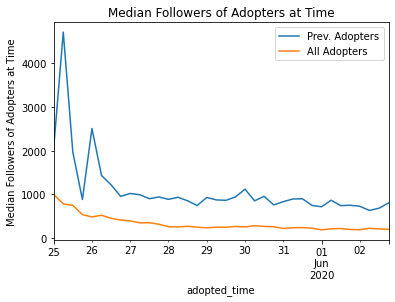

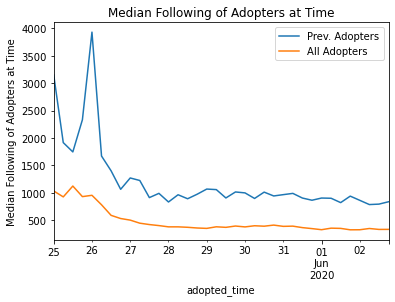

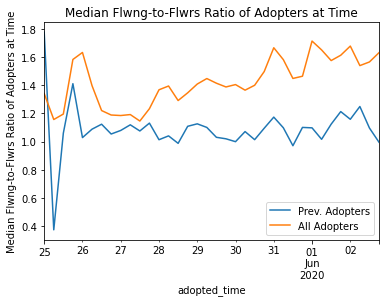

In [67]:
%matplotlib inline

users_df, _ = load_users_dfs()
users_w_info_gdf = users_df.merge(
    adopters_df, how="left", left_on="U_ID", right_index=True
)

users_w_info_gdf["Flwng-to-Flwrs Ratio"] = users_w_info_gdf["Following"] / users_w_info_gdf["Followers"]
prior_w_info_gdf = users_w_info_gdf[users_w_info_gdf["prior_adopter"]]

priors_by_qtrday_df = prior_w_info_gdf.groupby(
    pd.Grouper(key="adopted_time", freq='6h')
).agg({
    "Followers":"median",
    "Following":"median",
    "Flwng-to-Flwrs Ratio": "median"
})

ax1 = priors_by_qtrday_df.plot(use_index=True, y="Followers", label="Prev. Adopters")
ax2 = priors_by_qtrday_df.plot(use_index=True, y="Following", label="Prev. Adopters")       
ax3 = priors_by_qtrday_df.plot(use_index=True, y="Flwng-to-Flwrs Ratio", label="Prev. Adopters")

ax1.set_title("Median Followers of Adopters at Time")
ax2.set_title("Median Following of Adopters at Time")
ax3.set_title("Median Flwng-to-Flwrs Ratio of Adopters at Time")

ax1.set_ylabel("Median Followers of Adopters at Time")
ax2.set_ylabel("Median Following of Adopters at Time")
ax3.set_ylabel("Median Flwng-to-Flwrs Ratio of Adopters at Time")

adopters_by_qtrday_df = users_w_info_gdf.groupby(
    pd.Grouper(key="adopted_time", freq='6h')
).agg({
    "Followers":"median",
    "Following":"median",
    "Flwng-to-Flwrs Ratio": "median"
})

adopters_by_qtrday_df.plot(ax=ax1, use_index=True, y="Followers", label="All Adopters")
adopters_by_qtrday_df.plot(ax=ax2, use_index=True, y="Following", label="All Adopters")       
adopters_by_qtrday_df.plot(ax=ax3, use_index=True, y="Flwng-to-Flwrs Ratio", label="All Adopters")  

Text(0.5, 0, 'Time User Adopted')

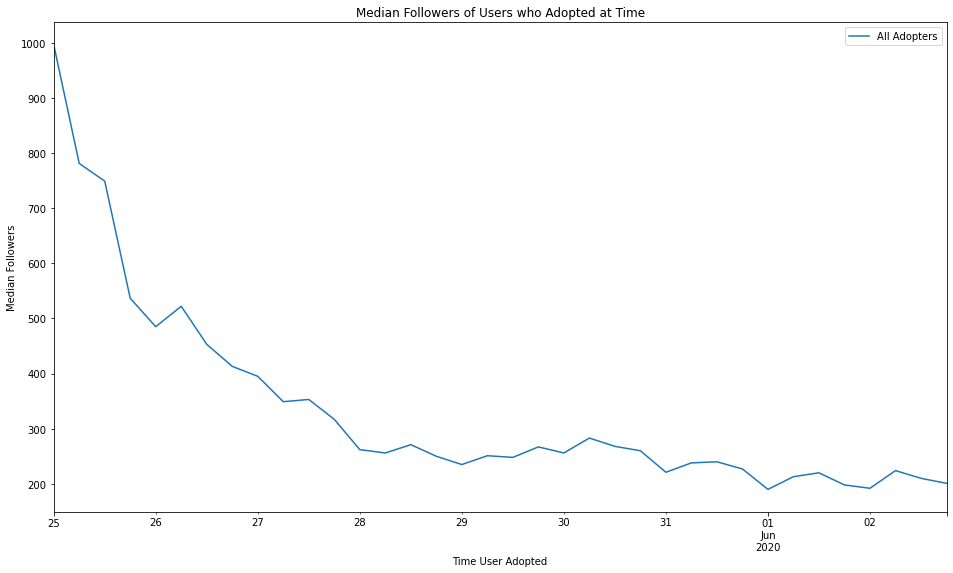

In [69]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

adopters_by_qtrday_df.plot(ax=ax, use_index=True, y="Followers", label="All Adopters")

ax.set_title("Median Followers of Users who Adopted at Time")
ax.set_ylabel("Median Followers")
ax.set_xlabel("Time User Adopted")

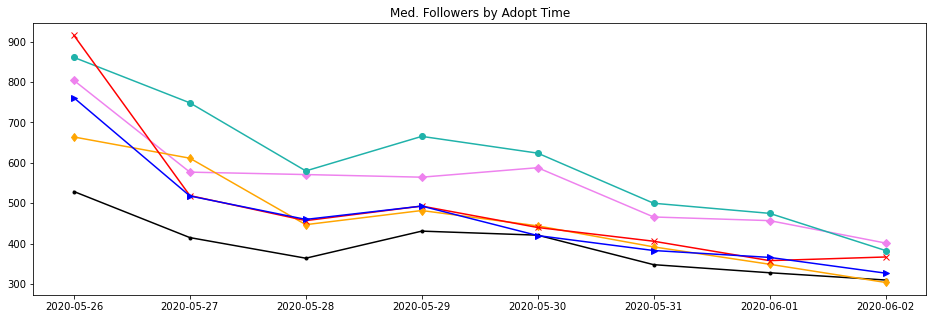

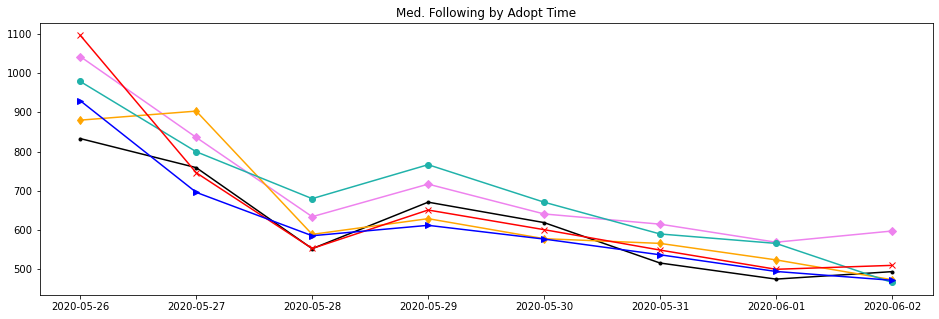

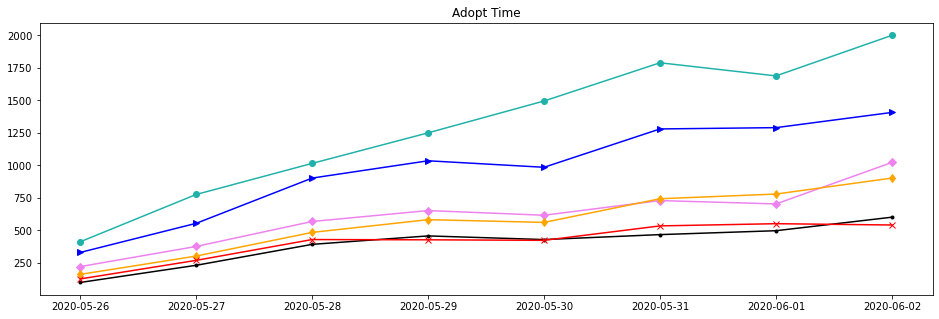

In [70]:
%matplotlib inline

fig, ax_1 = plt.subplots(1, 1, figsize=(16,5))
fig, ax_2 = plt.subplots(1, 1, figsize=(16,5))
fig, ax_3 = plt.subplots(1, 1, figsize=(16,5))

ax_1.set_title("Med. Followers by Adopt Time")
ax_2.set_title("Med. Following by Adopt Time")
ax_3.set_title("Adopt Time")

ax1.set_ylim(top=2000)
ax2.set_ylim(top=2000)

for cluster_label, cluster in adopters_clusters:
    
    cluster_filt = cluster.loc[cluster["adopted_time"] > "2020-05-26 12:00:00"]
    
    cluster_grpd = cluster_filt.groupby(
        pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "Followers":"median",
        "Following":"median",
        "U_ID": "count"
    })
    
    ax_1.plot(
        cluster_grpd.index,
        cluster_grpd["Followers"], 
        c=colors[cluster_label], 
        label=labels[cluster_label], 
        marker=markers[cluster_label],
    )
    ax_2.plot(
        cluster_grpd.index,
        cluster_grpd["Following"], 
        c=colors[cluster_label], 
        label=labels[cluster_label], 
        marker=markers[cluster_label],
    )
    ax_3.plot(
        cluster_grpd.index,
        cluster_grpd["U_ID"], 
        c=colors[cluster_label], 
        label=labels[cluster_label],
        marker=markers[cluster_label],
    )
    
ax1.set_ylim(top=2000)
ax2.set_ylim(top=2000)

ax1.legend()
ax2.legend()
ax3.legend()

In [63]:
grpd_gdf = geo_users_w_info_gdf.groupby(
    pd.Grouper(key="adopted_time", freq='24h')
).agg({
    "prior_adopter": "sum",
    "U_ID": "count"
})
grpd_gdf["prior_adopter"] = grpd_gdf["prior_adopter"].div(grpd_gdf["U_ID"])
grpd_gdf["prior_adopter"] = grpd_gdf["prior_adopter"]*100
grpd_gdf

,prior_adopter,U_ID
adopted_time,,
2020-05-25 00:00:00-04:00,85.000000,40
2020-05-26 00:00:00-04:00,67.697595,1455
2020-05-27 00:00:00-04:00,50.558214,2508
2020-05-28 00:00:00-04:00,36.675462,3790
2020-05-29 00:00:00-04:00,36.861231,4403
2020-05-30 00:00:00-04:00,32.335329,4509
2020-05-31 00:00:00-04:00,24.954890,5542
2020-06-01 00:00:00-04:00,20.787945,5508
2020-06-02 00:00:00-04:00,17.812452,6473


In [64]:
fig, ax = plt.subplots(1,1, figsize=(16,9))

ax.set_title("Percentage of New Adopters at Time who Had Previously Adopted")
ax.set_ylabel("Percent Previous Hashtag User")
ax.set_xlabel("Time User Adopted")

ax.plot(grpd_gdf.index, grpd_gdf["prior_adopter"], label="Prev. Adopters")

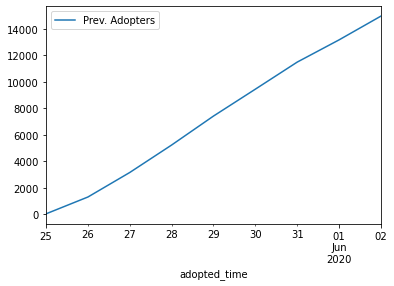

In [68]:
priors_by_qtrday_df = prior_w_info_gdf.groupby(
    pd.Grouper(key="adopted_time", freq='24h')
).agg({
    "U_ID": "count"
}).cumsum()

ax1 = priors_by_qtrday_df.plot(use_index=True, y="U_ID", label="Prev. Adopters")

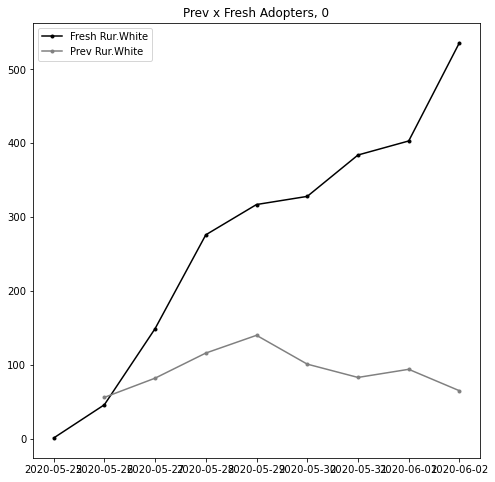

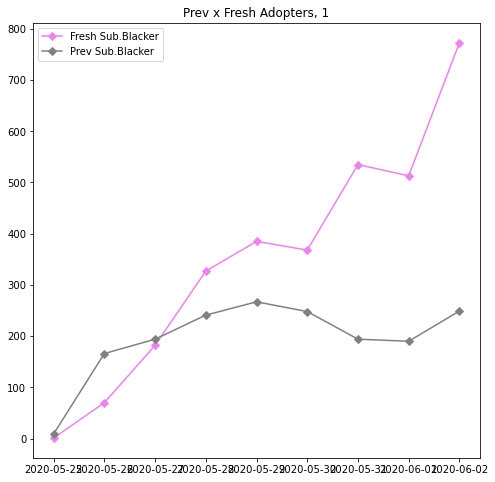

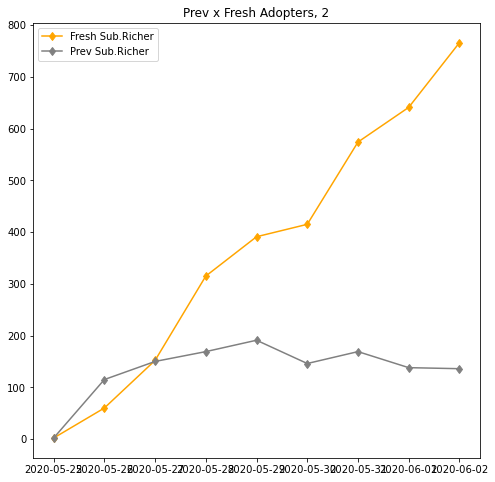

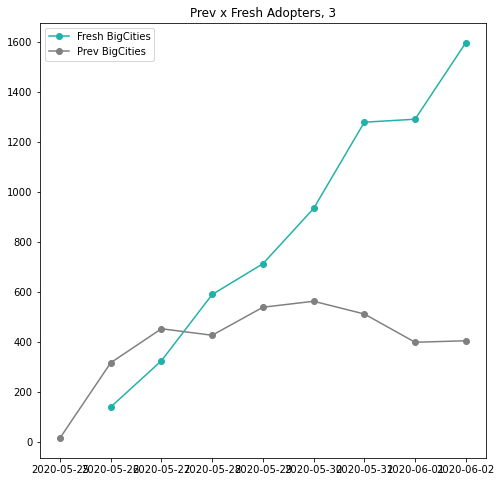

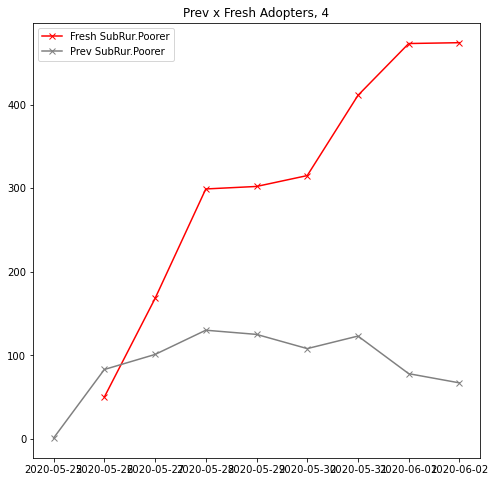

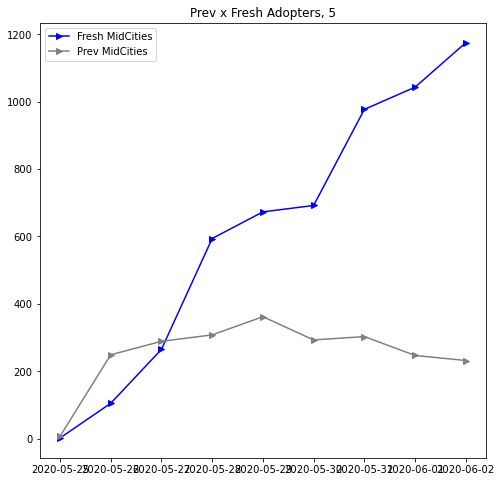

In [71]:
%matplotlib inline

for label, cluster in adopters_clusters:
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    
    fresh_cluster = cluster[~cluster["prior_adopter"]]
    prev_cluster = cluster[cluster["prior_adopter"]]
    
    prev_cluster_grpd = prev_cluster.groupby(
        pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "U_ID": "count"
    })
    
    fresh_cluster_grpd = fresh_cluster.groupby(
        pd.Grouper(key="adopted_time", freq='24h')
    ).agg({
        "U_ID": "count"
    })
    
    ax.set_title(f"Prev x Fresh Adopters, {label}")
    
    ax.plot(
        fresh_cluster_grpd.index,
        fresh_cluster_grpd["U_ID"], 
        c=colors[label], 
        label=f"Fresh {labels[label]}", 
        marker=markers[label],
    )
    
    ax.plot(
        prev_cluster_grpd.index,
        prev_cluster_grpd["U_ID"], 
        c="grey", 
        label=f"Prev {labels[label]}", 
        marker=markers[label],
    )

    ax.legend()

## View Top Users Followed by Each Group

Removing this analysis results for my publicly available Code to protect user anonymity, but provided code below to allow reproducibility.

In [ ]:
edges_df = load_edges_df()

In [ ]:
for label, cluster in adopters_clusters:
    
    print(f"LABEL {label}, {labels[label]}")
    
    followed_by_df = edges_df.loc[edges_df["Target"].isin(cluster["U_ID"])]
    followed_by_df = followed_by_df.groupby(["Source"]).agg({
        "Target": "count"
    })
    print(followed_by_df.sort_values(by="Target", ascending=False).head())
    print()
    